In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
GSPC = pd.read_csv('GSPC_index_close_test123.csv')
GSPC['Date']=pd.to_datetime(GSPC['Date'])
GSPC.set_index('Date', inplace=True)
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,100,axis=0), columns=GSPC.columns)
GSPC_noisy

Date   2017-01-03  2017-01-04  2017-01-05  2017-01-06   2017-01-09  \
0     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
1     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
2     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
3     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
4     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
..            ...         ...         ...         ...          ...   
95    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
96    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
97    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
98    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
99    2257.830078     2270.75      2269.0  2276.97998  2268.899902   

Date   2017-01-10   2017-01-11   2017-01-12   2017-01-13   2017-01-17  ...  \
0     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
1     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
2     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
3     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
4     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
..            ...          ...          ...          ...          ...  ...   
95    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
96    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
97    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
98    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
99    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   

Date   2018-12-17   2018-12-18   2018-12-19   2018-12-20   2018-12-21  \
0     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
1     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
2     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
3     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
4     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
..            ...          ...          ...          ...          ...   
95    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
96    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
97    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
98    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
99    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   

Date   2018-12-24   2018-12-26   2018-12-27  2018-12-28   2018-12-31  
0     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
1     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
2     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
3     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
4     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
..            ...          ...          ...         ...          ...  
95    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
96    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
97    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
98    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
99    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  

[100 rows x 502 columns]

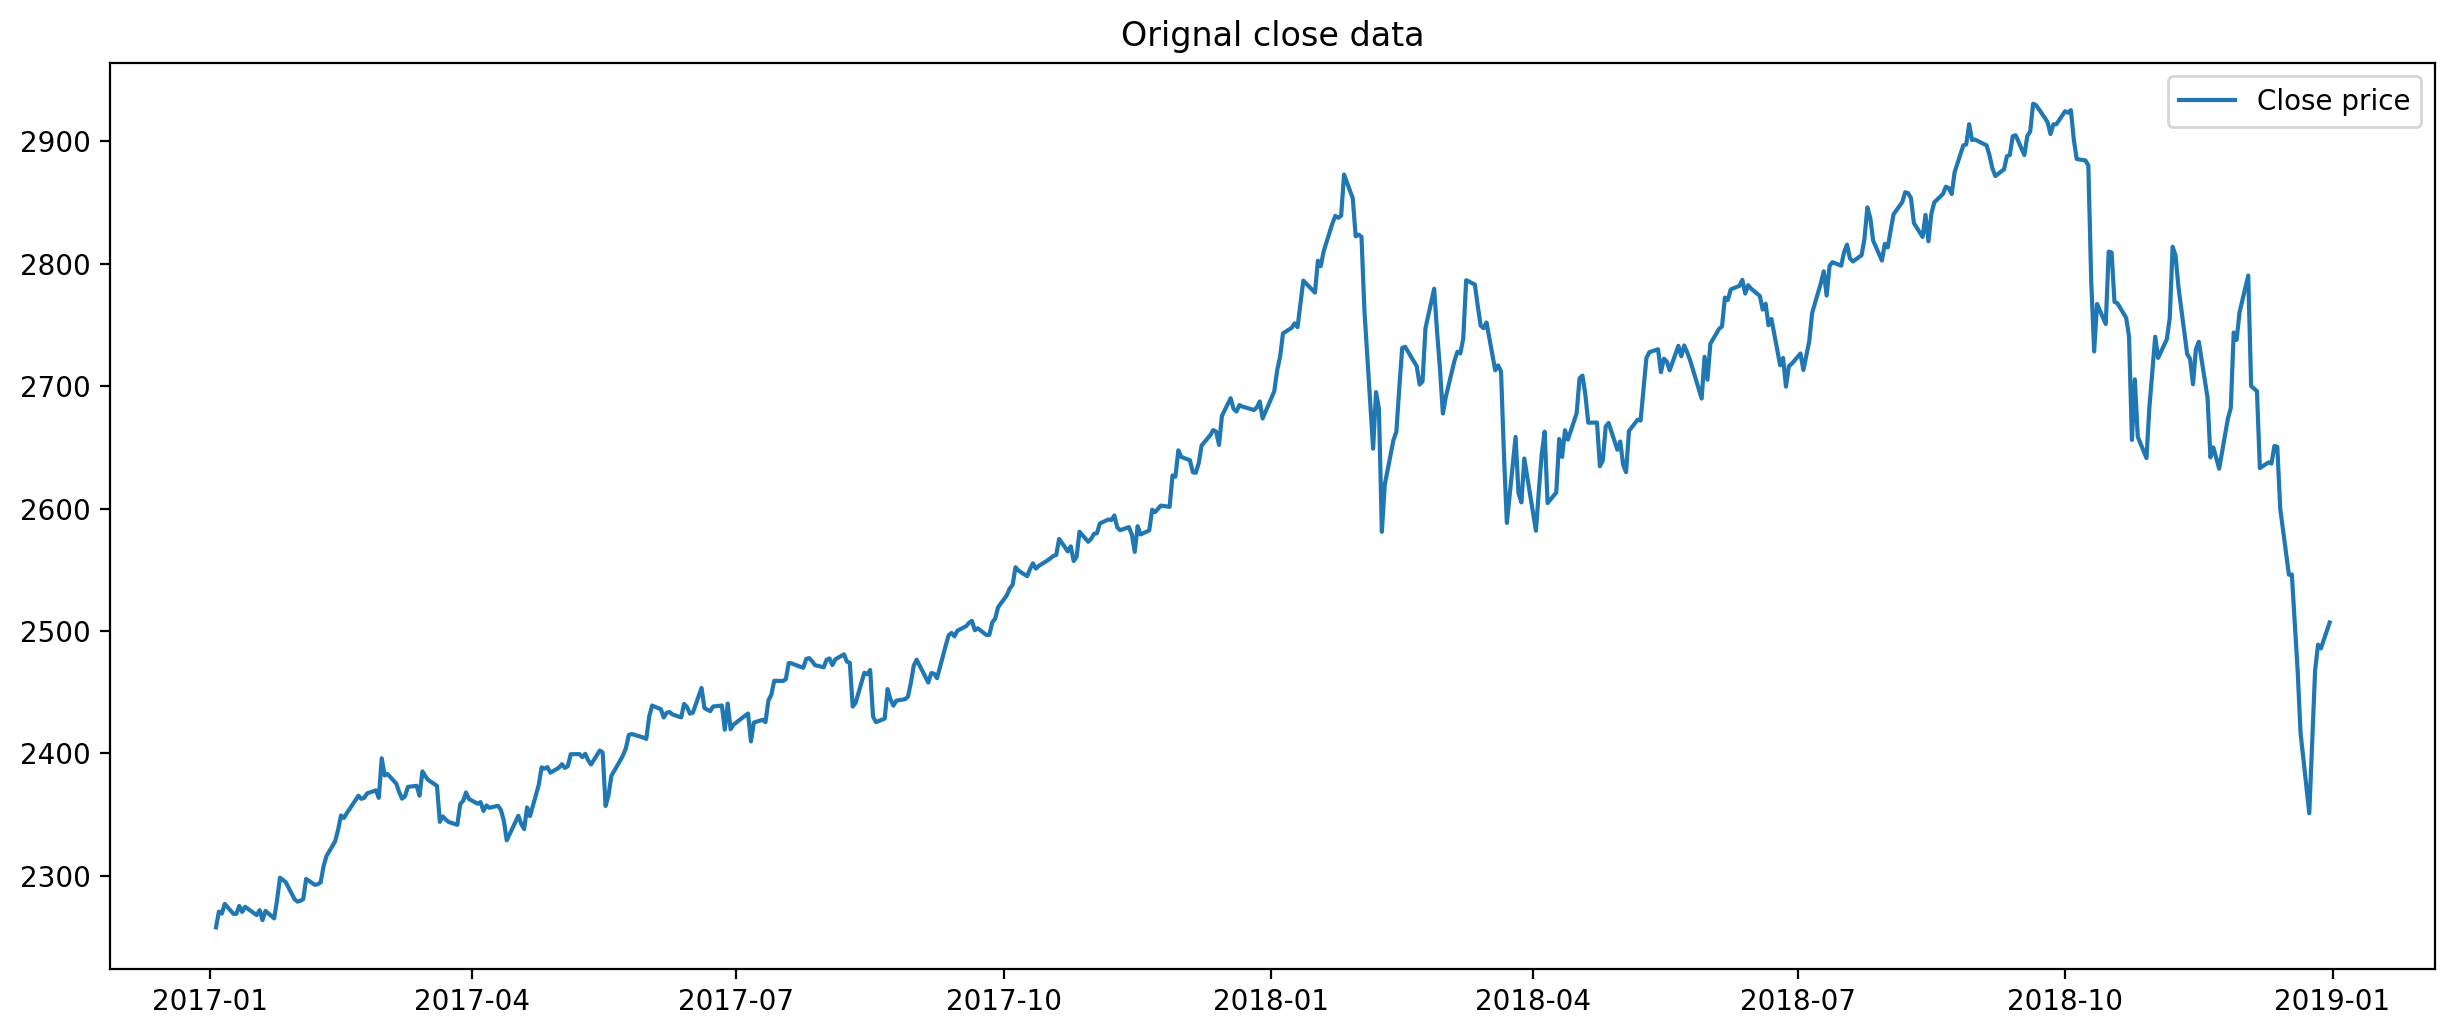

In [3]:
plt.figure(figsize=(15,6),dpi=200)
plt.plot(GSPC_noisy.iloc[0],label='Close price')
plt.title('Orignal close data')
plt.legend()

In [4]:
GSPC_T=GSPC.T
GSPC_pure=pd.DataFrame(columns=GSPC.columns)
for window in range(2,52):#SMA and EMA of the day, which using today's price and is the next day's SMA and EMA
    rolling_mean = GSPC_T['Close'].rolling(window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  GSPC_T['Close'].ewm(span=window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
GSPC_pure#


Date   2017-01-03   2017-01-04   2017-01-05   2017-01-06   2017-01-09  \
0     2257.830078  2264.290039     2269.875   2272.98999  2272.939941   
1     2257.830078  2264.290039  2265.860026  2272.243327  2271.626628   
2     2257.830078  2264.290039  2265.860026  2268.640015  2271.407471   
3     2257.830078  2264.290039  2265.860026  2268.640015  2268.691992   
4     2257.830078  2264.290039  2265.860026  2268.640015  2268.691992   
..            ...          ...          ...          ...          ...   
95    2257.830078  2264.427485  2266.016965  2268.935088   2268.92744   
96    2257.830078  2264.424622  2266.013727  2268.928967   2268.92266   
97    2257.830078  2264.421875  2266.010619  2268.923095   2268.91807   
98    2257.830078  2264.419238  2266.007635  2268.917456  2268.913659   
99    2257.830078  2264.416705  2266.004766  2268.912038  2268.909417   

Date   2017-01-10   2017-01-11   2017-01-12   2017-01-13   2017-01-17  ...  \
0     2268.899902  2272.109985  2272.880005  2272.539917  2271.264893  ...   
1     2271.593262  2271.039958  2271.553304  2273.466634  2270.989909  ...   
2     2270.944946  2272.524963  2270.889954  2272.324951  2272.072449  ...   
3     2270.905957  2271.819971  2272.107959  2271.639941  2271.437939  ...   
4     2268.726644  2271.641642  2271.589966  2272.529948  2271.014933  ...   
..            ...          ...          ...          ...          ...  ...   
95    2268.922348  2269.957027  2270.026755  2270.630799  2270.301319  ...   
96    2268.918461  2269.951171   2270.02154  2270.624275  2270.296787  ...   
97    2268.914725  2269.945548  2270.016528  2270.618008  2270.292425  ...   
98    2268.911131  2269.940144  2270.011708  2270.611983  2270.288223  ...   
99    2268.907671  2269.934947  2270.007068  2270.606186  2270.284172  ...   

Date   2018-12-17   2018-12-18   2018-12-19   2018-12-20   2018-12-21  \
0     2572.944946  2546.049927  2526.559937  2487.189941   2442.02002   
1     2598.809977  2564.016602  2533.019938  2506.846598  2463.666667   
2        2611.875  2585.647461  2549.752441  2516.619934  2484.289978   
3     2616.856006  2598.731982  2569.909961  2533.285937  2496.619971   
4     2620.333333  2605.073324  2583.436646  2552.828288  2513.841634   
..            ...          ...          ...          ...          ...   
95    2716.633637  2709.530565  2701.090123  2691.353864  2679.906625   
96    2717.947105  2710.935383  2702.609856  2693.010266  2681.729036   
97    2719.229206  2712.306434  2704.092575  2694.625669  2683.505447   
98    2720.480251  2713.644159  2705.538897  2696.200898  2685.236945   
99    2721.700579  2714.949014  2706.949435  2697.736762  2686.924583   

Date   2018-12-24   2018-12-26   2018-12-27   2018-12-28   2018-12-31  
0     2383.860107  2409.400024  2478.265015  2487.285034  2496.295044  
1     2411.713379  2411.806722  2435.876709  2480.756673  2493.806722  
2     2435.525024  2425.710022  2431.062561  2448.342529  2487.280029  
3     2457.652002   2441.96001  2438.334033  2441.998047  2460.044043  
4     2472.366659   2459.32666  2449.771688  2446.235026  2452.806722  
..            ...          ...          ...          ...          ...  
95    2666.206353  2657.935253  2650.889204  2644.007987  2638.293075  
96    2668.233977  2660.048915  2653.060391  2646.230987  2640.541971  
97    2670.209233  2662.108862   2655.17771  2648.400202  2642.738197  
98     2672.13354  2664.116536  2657.242557  2650.516966  2644.882972  
99    2674.008257  2666.073322  2659.256274  2652.582571  2646.977476  

[100 rows x 502 columns]

## MinMaxScaler

In [5]:
mm = MinMaxScaler()
noise_mm = mm.fit_transform(GSPC_noisy.T).T
prue_mm=mm.transform(GSPC_pure.T).T
prue_mm.shape

(100, 502)

In [6]:
train_cleaned_mm=np.reshape(prue_mm, (100, 502, 1))
train_mm=np.reshape(noise_mm, (100, 502, 1))

In [7]:
# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_cleaned_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## LSTM

In [18]:
def set_model_LSTM():
    model = Sequential()
    model.add(LSTM(64, input_shape=(None, 1),activation='relu', return_sequences = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(32, activation='relu',return_sequences = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(AveragePooling1D(2, padding='same'))
    model.add(LSTM(32, activation='relu',return_sequences = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(64, activation='relu',return_sequences = True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(UpSampling1D(2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 64)          16896     
                                                                 
 batch_normalization_8 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 batch_normalization_9 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, None, 32)         

In [22]:
callback = EarlyStopping(monitor='loss', patience=30)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/400
2/2 [==============================] - 5s 798ms/step - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 2/400
2/2 [==============================] - 1s 367ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 3/400
2/2 [==============================] - 1s 366ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 4/400
2/2 [==============================] - 1s 366ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 5/400
2/2 [==============================] - 1s 367ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 6/400
2/2 [==============================] - 1s 374ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 7/400
2/2 [==============================] - 1s 367ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 8/400
2/2 [==============================] - 1s 369ms/step - loss: 0.0116 - m

In [23]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [19]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

In [10]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mse = history_LSTM.history['mse']
epoch_val_mse = history_LSTM.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

NameError: name 'history_LSTM' is not defined

In [20]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
GSPC_test['Date']=pd.to_datetime(GSPC_test['Date'])
GSPC_test.set_index('Date', inplace=True)
GSPC_test

Close
Date                   
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

[502 rows x 1 columns]

1/1 [==============================] - 0s 474ms/step


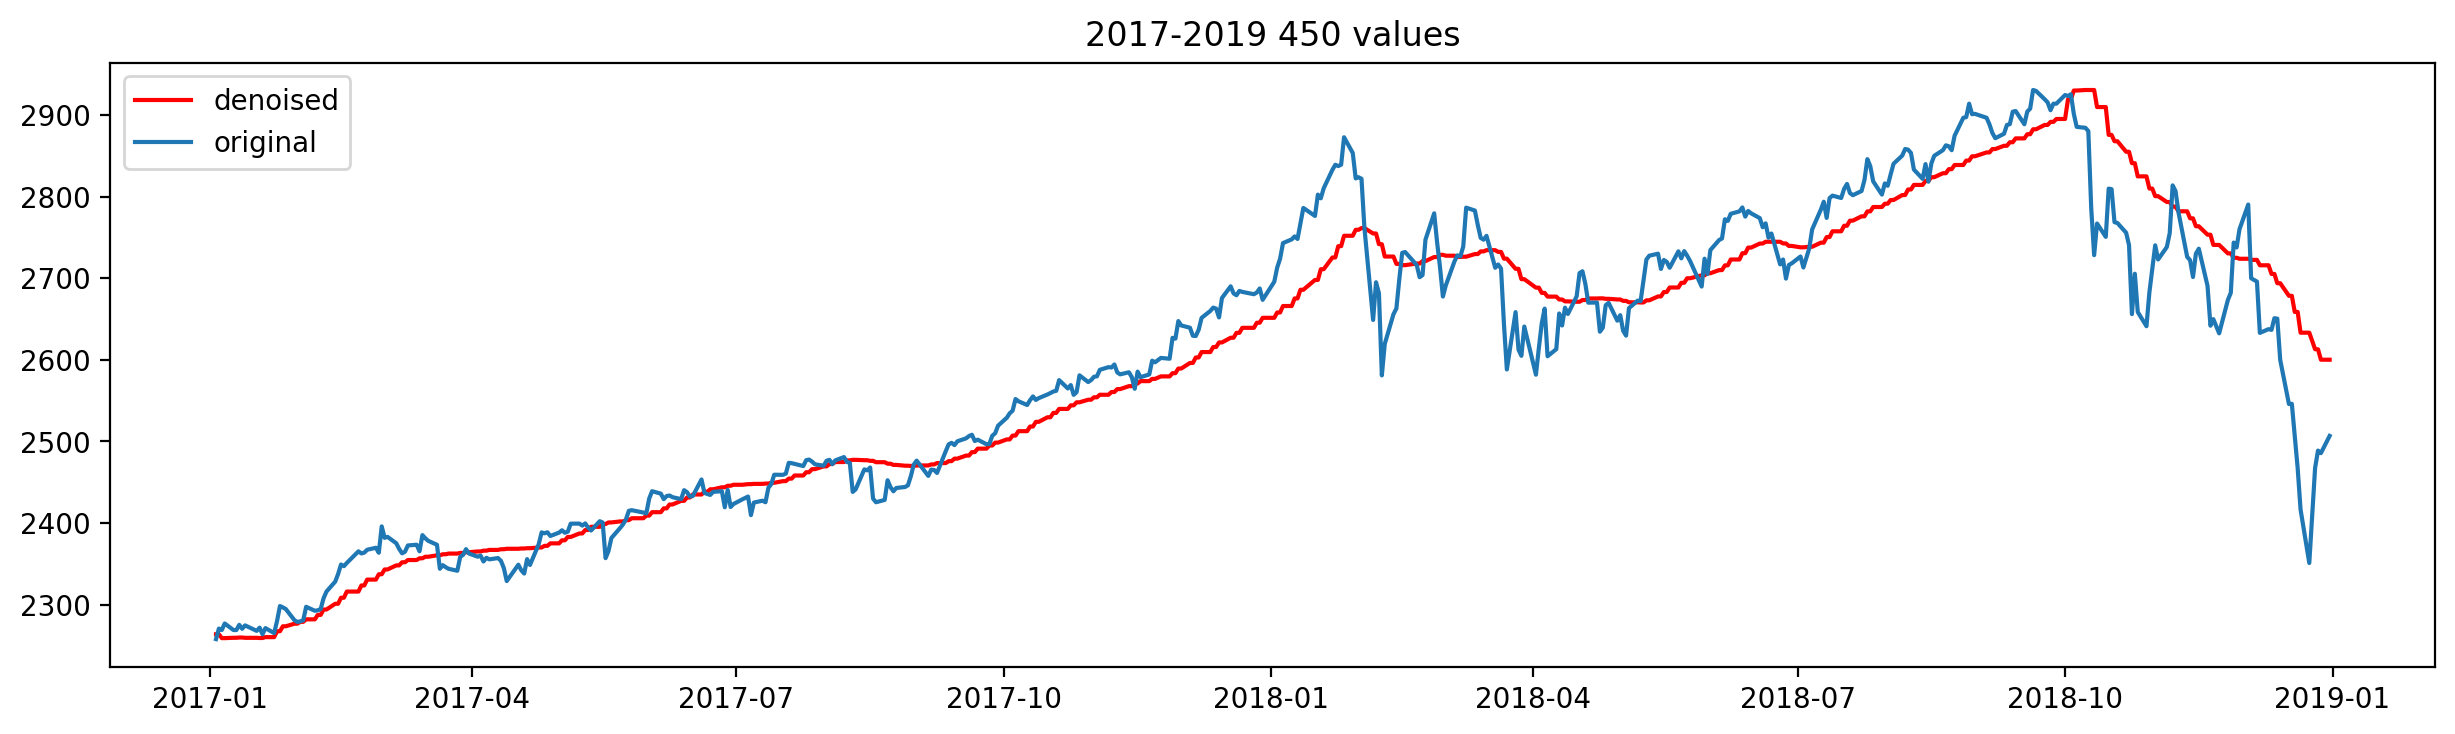

In [21]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((502,1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [9]:
def set_model_encoding_mm():
    model = Sequential()
    #encoding
    model.add(Conv1D(64, kernel_size=3, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv1D(32, kernel_size=3,activation='tanh',padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    #Use the normalization preprocessing of the data as mentioned before, so that the input x does not vary too much
    model.add(AveragePooling1D(2, padding='same'))
    #decoding
    model.add(Conv1D(32, kernel_size=3, activation='tanh', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv1D(64, kernel_size=3,activation='tanh',padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(UpSampling1D(2))
    
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 batch_normalization_4 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          6176      
                                                                 
 batch_normalization_5 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, None, 32)         

In [29]:
callback = EarlyStopping(monitor='loss', patience=30)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/400
5/5 [==============================] - 2s 71ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 2/400
5/5 [==============================] - 0s 30ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 3/400
5/5 [==============================] - 0s 29ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 4/400
5/5 [==============================] - 0s 29ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 5/400
5/5 [==============================] - 0s 29ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 6/400
5/5 [==============================] - 0s 30ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 7/400
5/5 [==============================] - 0s 29ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 8/400
5/5 [==============================] - 0s 30ms/step - loss: 0.0109 - mse: 0.01

In [30]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

In [10]:
modelen_mm.load_weights('model_weights_mm.h5') 

In [11]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

NameError: name 'history_mm' is not defined

1/1 [==============================] - 0s 227ms/step


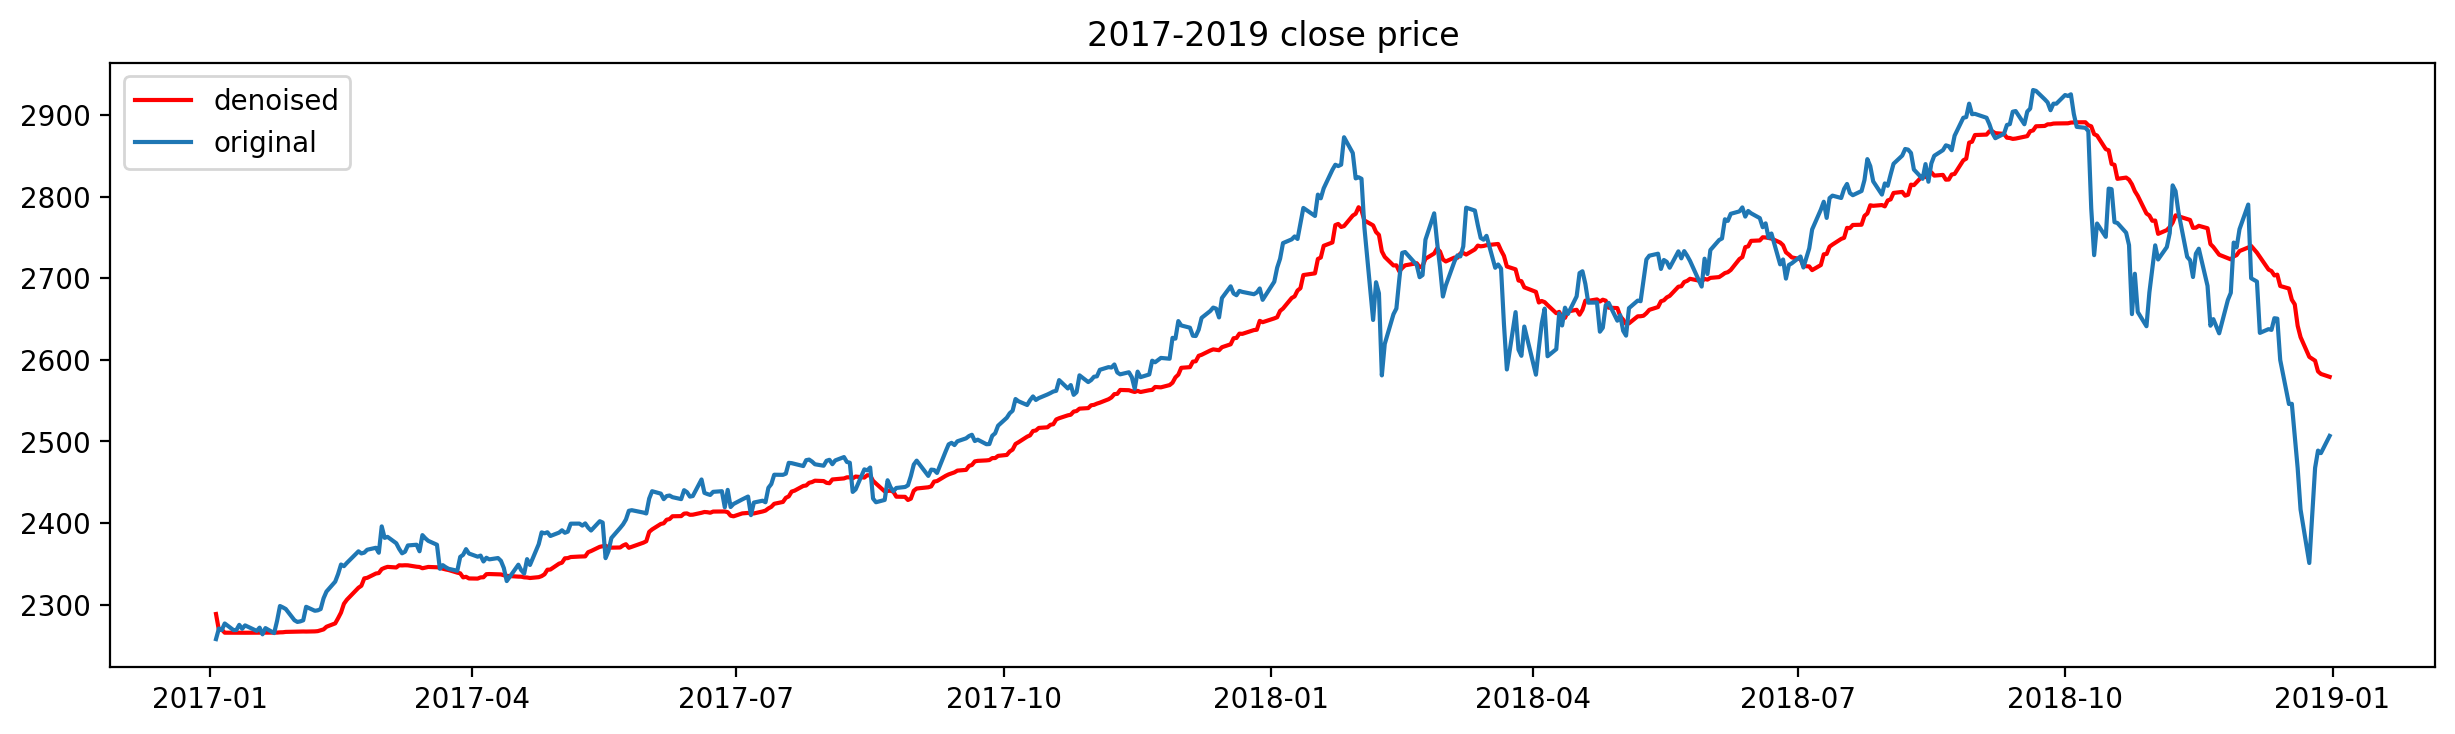

In [14]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T, batch_size=32)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((502,1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 close price')
plt.legend(['denoised', 'original'], loc='upper left')

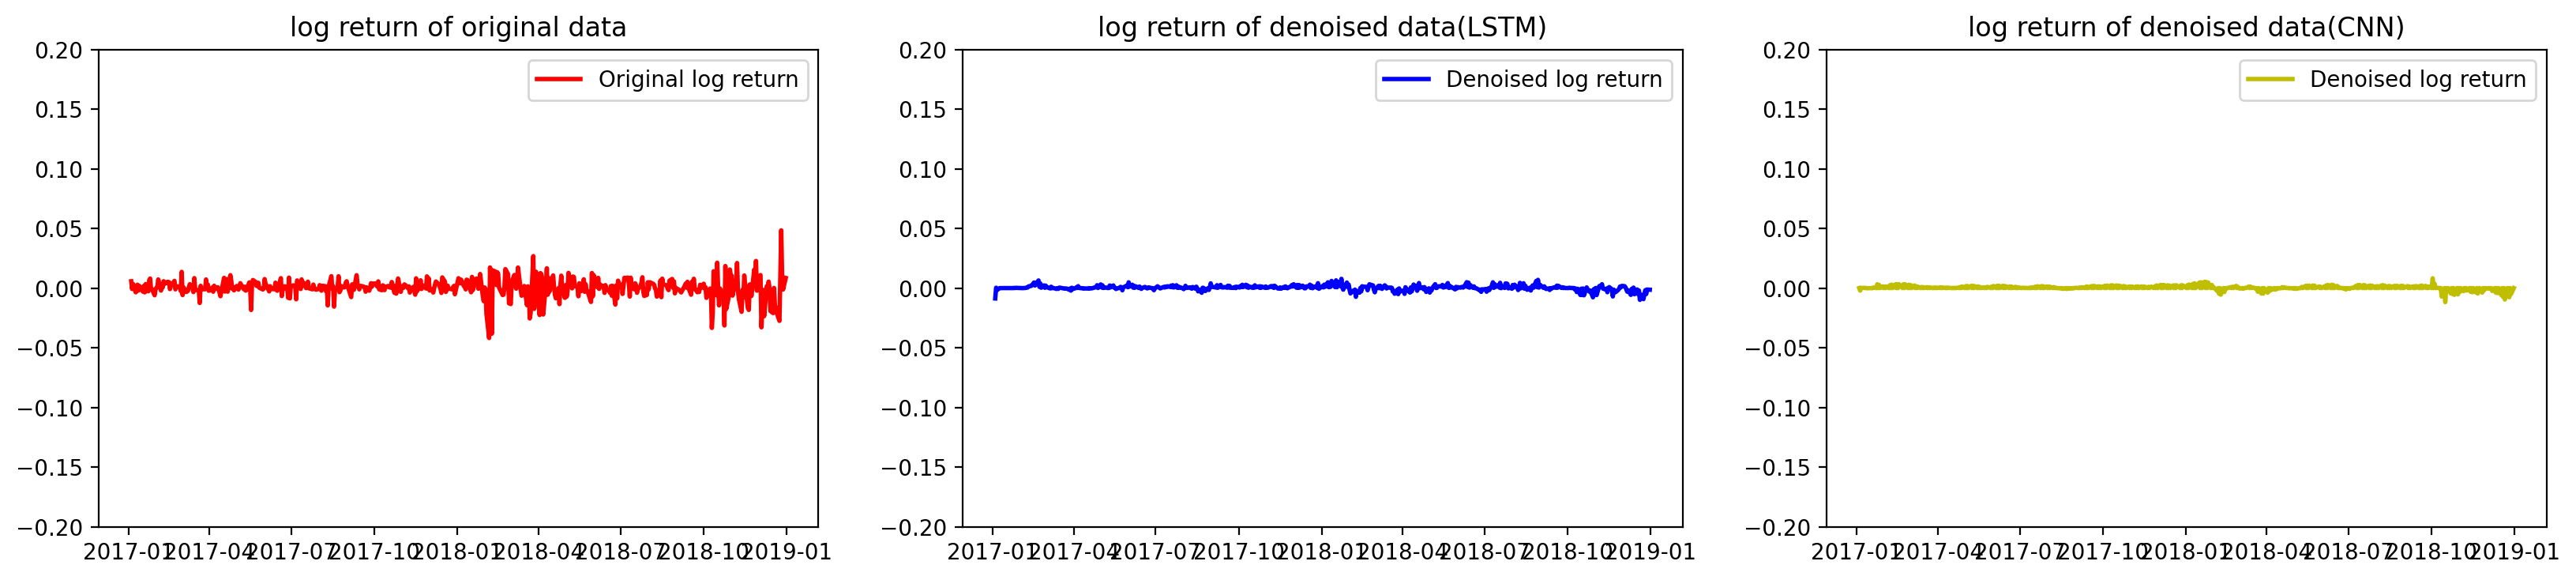

In [22]:
# Log Returns
GSPC_test['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,3,1)
plt.plot(GSPC_test['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(LSTM)')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(pure_mm_lstm['log_ret'], 'y-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

plt.show()

In [83]:
pure_mm_lstm.describe()

Close     log_ret
count   502.000000  501.000000
mean   2596.032959    0.000277
std     180.721725    0.001767
min    2259.009766   -0.011790
25%    2447.161255    0.000000
50%    2633.338135    0.000000
75%    2736.846313    0.001196
max    2930.749756    0.008233

In [83]:
pure_mm_lstm.describe()

Close     log_ret
count   502.000000  501.000000
mean   2596.032959    0.000277
std     180.721725    0.001767
min    2259.009766   -0.011790
25%    2447.161255    0.000000
50%    2633.338135    0.000000
75%    2736.846313    0.001196
max    2930.749756    0.008233

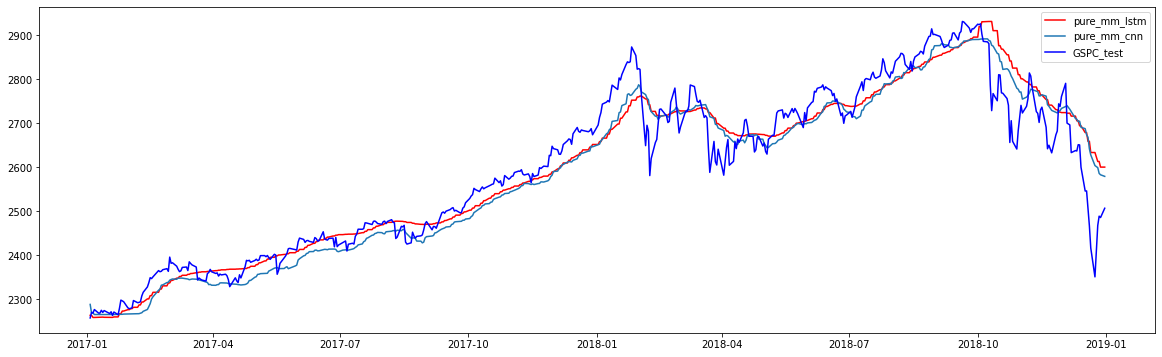

In [40]:
plt.figure(figsize=(20,6))
plt.plot(pure_mm_lstm['Close'],'r-',label='pure_mm_lstm')
plt.plot(pure_mm_cnn['Close'],label='pure_mm_cnn')
plt.plot(GSPC_test['Close'],'b-',label='GSPC_test')
plt.legend()

In [47]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [84]:
def svmf1(dataset,long_predict=10):
    f1=np.empty(0)
    for n in np.arange(0.0, 0.007, 0.0005):#get multiple threshold
        threshold = n
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=2,error_score=1).mean())
    return f1

In [85]:
original_svm=svmf1(GSPC_test,long_predict=5)

In [86]:
denoised_svm=svmf1(pure_mm_cnn,long_predict=5)

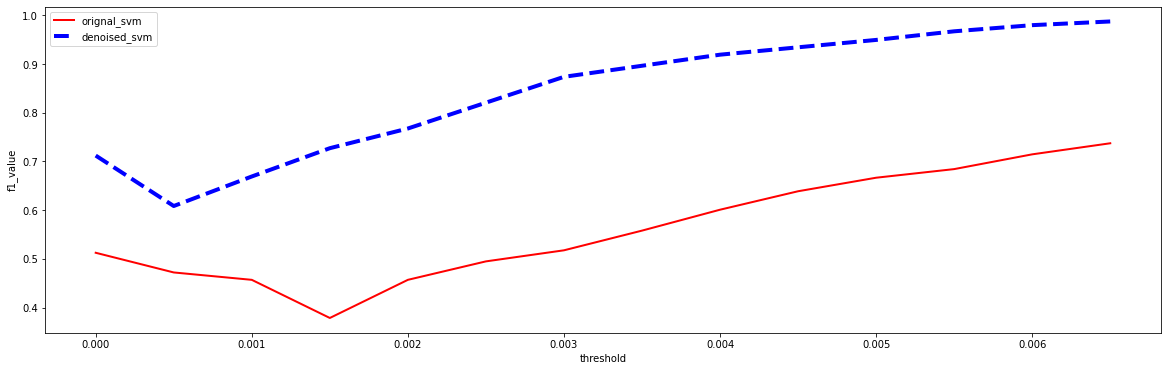

In [87]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.007, 0.0005),original_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.007, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.007, 0.001))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## LSTM

In [88]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

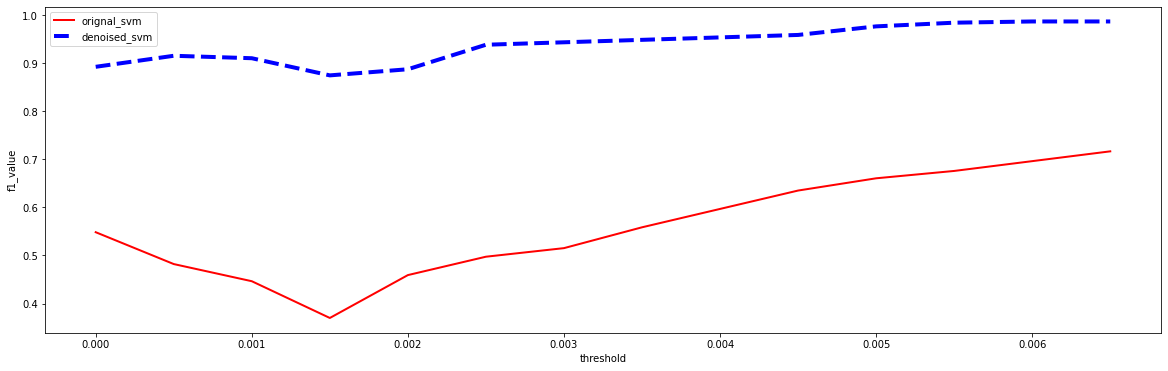

In [90]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.007, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.007, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.007, 0.001))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Bollinger band

In [94]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()
    rolling_std = close_prices.rolling(window,min_periods=1).std()
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

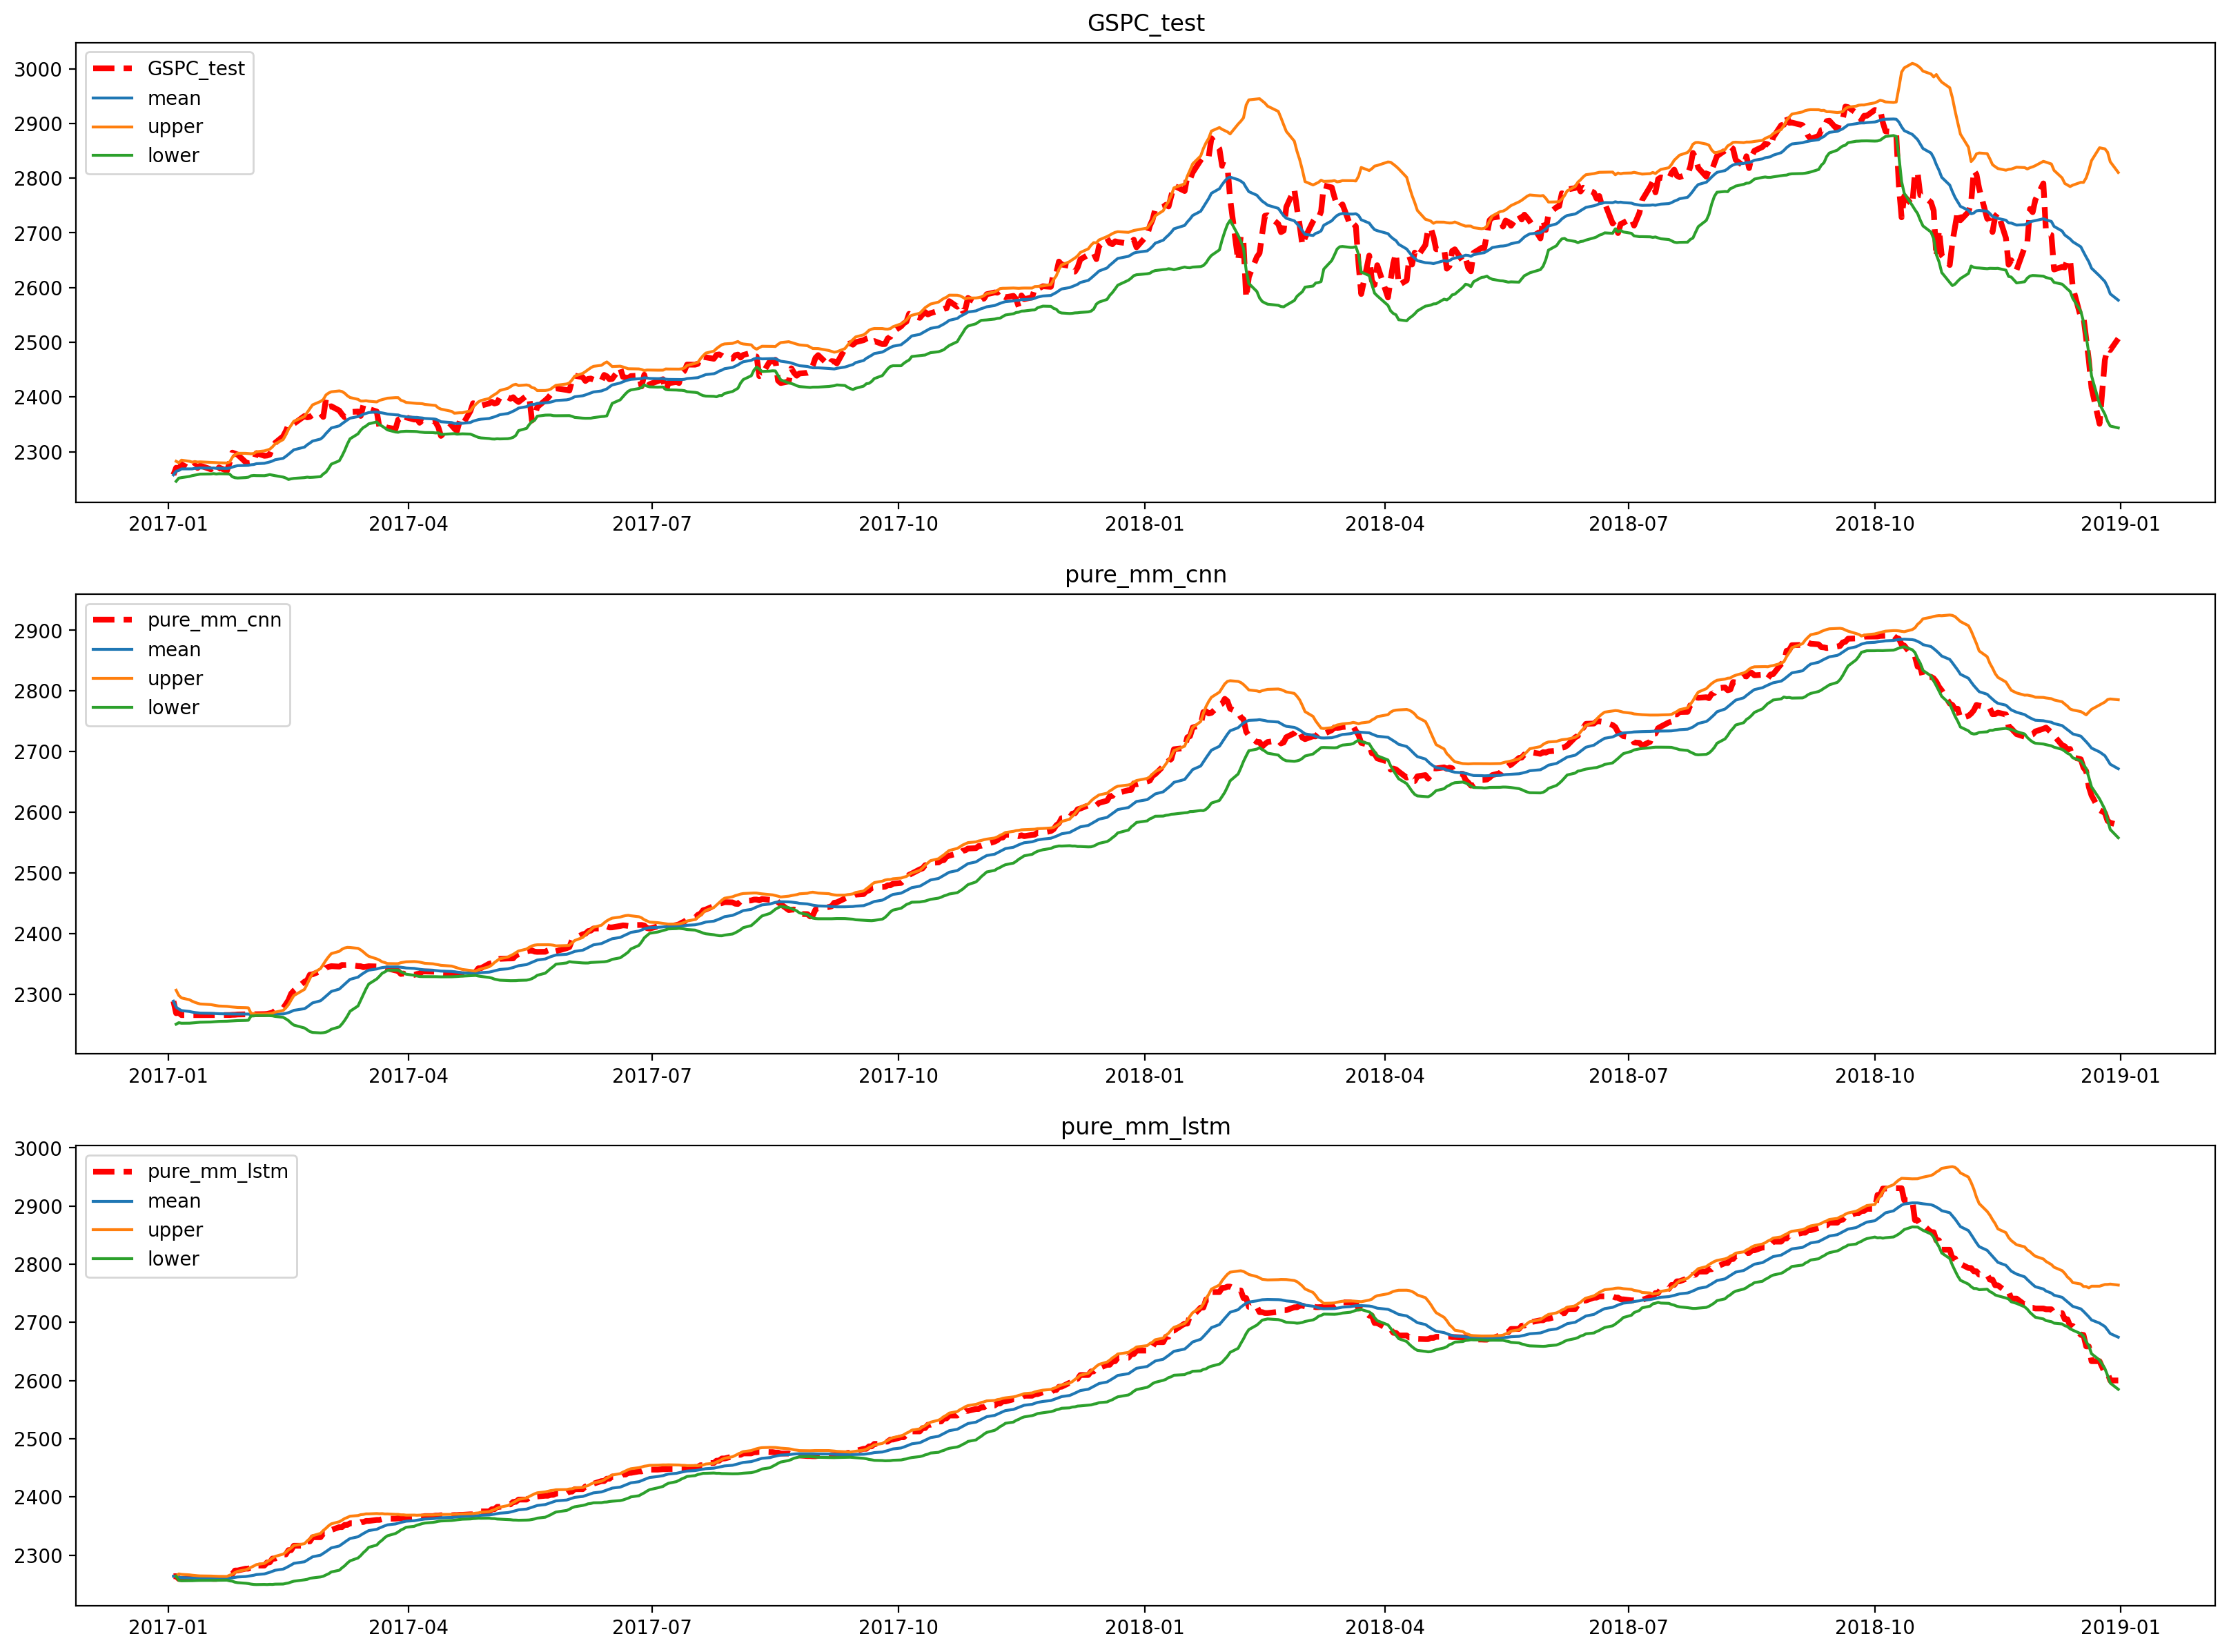

In [95]:
GSPC_test_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_lstm_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_cnn_bb=pd.DataFrame(columns=['mean','upper','lower'])
GSPC_test_bb['mean'],GSPC_test_bb['upper'],GSPC_test_bb['lower']=bbands(GSPC_test['Close'],20,2)
pure_mm_cnn_bb['mean'],pure_mm_cnn_bb['upper'],pure_mm_cnn_bb['lower']=bbands(pure_mm_cnn['Close'],20,2)
pure_mm_lstm_bb['mean'],pure_mm_lstm_bb['upper'],pure_mm_lstm_bb['lower']=bbands(pure_mm_lstm['Close'],20,2)

plt.figure(figsize=(20,15),dpi=200)

plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'],label='GSPC_test', color='red', linewidth=3.0, linestyle='--')
plt.plot(GSPC_test_bb['mean'],label='mean')
plt.plot(GSPC_test_bb['upper'],label='upper')
plt.plot(GSPC_test_bb['lower'],label='lower')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Close'],label='pure_mm_cnn', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_cnn_bb['mean'],label='mean')
plt.plot(pure_mm_cnn_bb['upper'],label='upper')
plt.plot(pure_mm_cnn_bb['lower'],label='lower')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.title('pure_mm_lstm')
plt.plot(pure_mm_lstm['Close'],label='pure_mm_lstm', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_lstm_bb['mean'],label='mean')
plt.plot(pure_mm_lstm_bb['upper'],label='upper')
plt.plot(pure_mm_lstm_bb['lower'],label='lower')
plt.legend(loc='best')

In [96]:
def buy_signal_function(dataset,dataset1,dataset2,dataset3):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Close']
    buy_signal['GSPC_test']=dataset1['Close']
    buy_signal['pure_mm_cnn']=dataset2['Close']
    buy_signal['pure_mm_lstm']=dataset3['Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,6]):
            buy_signal.iloc[i,7]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,6]):
                buy_signal.iloc[i,8]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,5]):
            buy_signal.iloc[i,7]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,5]):
                buy_signal.iloc[i,8]=-1
    return buy_signal

In [99]:
GSPC_test_signal=buy_signal_function(GSPC_test,GSPC_test,pure_mm_cnn,pure_mm_lstm)
GSPC_test_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2257.830078  2257.830078  2288.590576   2263.761475  2257.830078   
2017-01-04  2270.750000  2270.750000  2268.782227   2263.761475  2264.290039   
2017-01-05  2269.000000  2269.000000  2269.447510   2259.009766  2265.860026   
2017-01-06  2276.979980  2276.979980  2265.678711   2259.009766  2268.640015   
2017-01-09  2268.899902  2268.899902  2265.628174   2259.451172  2268.691992   
...                 ...          ...          ...           ...          ...   
2018-12-24  2351.100098  2351.100098  2603.703369   2633.338135  2621.355005   
2018-12-26  2467.699951  2467.699951  2599.004883   2613.029541  2611.067505   
2018-12-27  2488.830078  2488.830078  2585.927002   2613.029541  2601.400513   
2018-12-28  2485.739990  2485.739990  2582.783447   2600.222656  2588.498010   
2018-12-31  2506.850098  2506.850098  2579.210938   2600.222656  2576.950513   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2282.561568  2246.018510   NaN     NaN  
2017-01-05  2279.877968  2251.842084   NaN     NaN  
2017-01-06  2284.597934  2252.682096   NaN     NaN  
2017-01-09  2282.513910  2254.870074   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2855.525843  2387.184167   1.0     NaN  
2018-12-26  2853.533021  2368.601989   NaN     NaN  
2018-12-27  2847.322054  2355.478972   NaN     NaN  
2018-12-28  2830.002400  2346.993621   NaN     NaN  
2018-12-31  2810.346110  2343.554916   NaN     NaN  

[502 rows x 9 columns]

In [100]:
GSPC_test_signal[~np.isnan(GSPC_test_signal['signal'])]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-25  2298.370117  2298.370117  2266.111084   2267.472412  2271.948730   
2017-02-10  2316.100098  2316.100098  2272.956299   2294.078613  2285.315002   
2017-02-21  2365.379883  2365.379883  2320.755127   2316.084473  2308.526013   
2017-03-21  2344.020020  2344.020020  2345.358398   2360.511475  2371.690503   
2017-04-13  2328.949951  2328.949951  2335.309814   2368.532227  2354.799988   
2017-04-25  2388.610107  2388.610107  2335.012939   2370.102051  2355.846985   
2017-06-02  2439.070068  2439.070068  2392.238770   2413.374512  2400.479480   
2017-06-29  2419.699951  2419.699951  2409.075439   2445.759521  2434.710498   
2017-07-06  2409.750000  2409.750000  2411.708008   2447.719727  2432.563989   
2017-07-14  2459.270020  2459.270020  2423.656250   2449.407227  2433.704492   
2017-07-19  2473.830078  2473.830078  2432.710938   2454.490479  2437.201501   
2017-08-10  2438.209961  2438.209961  2454.819824   2477.516602  2470.625000   
2017-08-17  2430.010010  2430.010010  2451.793701   2476.307861  2467.804517   
2017-09-12  2496.479980  2496.479980  2459.679443   2475.919189  2456.303040   
2017-10-05  2552.070068  2552.070068  2496.960449   2507.253906  2507.264539   
2017-10-27  2581.070068  2581.070068  2540.268066   2548.007324  2555.292493   
2017-11-28  2627.040039  2627.040039  2572.034180   2583.727295  2588.366516   
2018-01-04  2723.989990  2723.989990  2660.048584   2658.086426  2675.422034   
2018-01-12  2786.239990  2786.239990  2703.976074   2685.933594  2707.396021   
2018-02-05  2648.939941  2648.939941  2764.834717   2754.915771  2797.145996   
2018-02-08  2581.000000  2581.000000  2733.039062   2741.822021  2782.674487   
2018-03-22  2643.689941  2643.689941  2727.487549   2724.070312  2731.898010   
2018-05-10  2723.070068  2723.070068  2657.237061   2673.009766  2669.530969   
2018-06-06  2772.350098  2772.350098  2706.412842   2715.835449  2725.366516   
2018-06-27  2699.629883  2699.629883  2731.814209   2742.693359  2755.600024   
2018-08-27  2896.739990  2896.739990  2844.578613   2838.852783  2846.597498   
2018-09-20  2930.750000  2930.750000  2881.221191   2882.641846  2893.628979   
2018-10-10  2785.679932  2785.679932  2886.250732   2930.749756  2902.534009   
2018-10-24  2656.100098  2656.100098  2815.152588   2841.038574  2824.689502   
2018-12-17  2545.939941  2545.939941  2687.479736   2678.549072  2674.510999   
2018-12-19  2506.959961  2506.959961  2668.081543   2658.793945  2655.816992   

                  upper        lower  side  signal  
Date                                                
2017-01-25  2289.604265  2254.293196  -1.0    -1.0  
2017-02-10  2314.329356  2256.300649  -1.0    -1.0  
2017-02-21  2364.342178  2252.709848  -1.0    -1.0  
2017-03-21  2393.846709  2349.534297   1.0     1.0  
2017-04-13  2377.951972  2331.648003   1.0     1.0  
2017-04-25  2381.494294  2330.199675  -1.0    -1.0  
2017-06-02  2438.181073  2362.777886  -1.0    -1.0  
2017-06-29  2449.404040  2420.016956   1.0     1.0  
2017-07-06  2451.308585  2413.819393   1.0     1.0  
2017-07-14  2457.687958  2409.721026  -1.0    -1.0  
2017-07-19  2469.862243  2404.540760  -1.0    -1.0  
2017-08-10  2490.153272  2451.096728   1.0     1.0  
2017-08-17  2496.262010  2439.347023   1.0     1.0  
2017-09-12  2494.627262  2417.978817  -1.0    -1.0  
2017-10-05  2546.911139  2467.617938  -1.0    -1.0  
2017-10-27  2580.859047  2529.725938  -1.0    -1.0  
2017-11-28  2614.652189  2562.080843  -1.0    -1.0  
2018-01-04  2721.502472  2629.341595  -1.0    -1.0  
2018-01-12  2782.193763  2632.598278  -1.0    -1.0  
2018-02-05  2898.804143  2695.487849   1.0     1.0  
2018-02-08  2933.756001  2631.592973   1.0     1.0  
2018-03-22  2803.319224  2660.476797   1.0     1.0  
2018-05-10  2721.754235  2617.307704  -1.0    -1.0  
2018-06-06  2761.762875  2688.970158  -1.0    -1.0  

In [101]:
GSPC_test_signal[GSPC_test_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-03-21  2344.020020  2344.020020  2345.358398   2360.511475  2371.690503   
2017-04-13  2328.949951  2328.949951  2335.309814   2368.532227  2354.799988   
2017-06-29  2419.699951  2419.699951  2409.075439   2445.759521  2434.710498   
2017-07-06  2409.750000  2409.750000  2411.708008   2447.719727  2432.563989   
2017-08-10  2438.209961  2438.209961  2454.819824   2477.516602  2470.625000   
2017-08-17  2430.010010  2430.010010  2451.793701   2476.307861  2467.804517   
2018-02-05  2648.939941  2648.939941  2764.834717   2754.915771  2797.145996   
2018-02-08  2581.000000  2581.000000  2733.039062   2741.822021  2782.674487   
2018-03-22  2643.689941  2643.689941  2727.487549   2724.070312  2731.898010   
2018-06-27  2699.629883  2699.629883  2731.814209   2742.693359  2755.600024   
2018-10-10  2785.679932  2785.679932  2886.250732   2930.749756  2902.534009   
2018-10-24  2656.100098  2656.100098  2815.152588   2841.038574  2824.689502   
2018-12-17  2545.939941  2545.939941  2687.479736   2678.549072  2674.510999   
2018-12-19  2506.959961  2506.959961  2668.081543   2658.793945  2655.816992   

                  upper        lower  side  signal  
Date                                                
2017-03-21  2393.846709  2349.534297   1.0     1.0  
2017-04-13  2377.951972  2331.648003   1.0     1.0  
2017-06-29  2449.404040  2420.016956   1.0     1.0  
2017-07-06  2451.308585  2413.819393   1.0     1.0  
2017-08-10  2490.153272  2451.096728   1.0     1.0  
2017-08-17  2496.262010  2439.347023   1.0     1.0  
2018-02-05  2898.804143  2695.487849   1.0     1.0  
2018-02-08  2933.756001  2631.592973   1.0     1.0  
2018-03-22  2803.319224  2660.476797   1.0     1.0  
2018-06-27  2809.395743  2701.804305   1.0     1.0  
2018-10-10  2965.285912  2839.782105   1.0     1.0  
2018-10-24  2989.320931  2660.058073   1.0     1.0  
2018-12-17  2792.343351  2556.678646   1.0     1.0  
2018-12-19  2800.499587  2511.134398   1.0     1.0

In [102]:
pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn,GSPC_test,pure_mm_cnn,pure_mm_lstm)
pure_mm_cnn_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2288.590576  2257.830078  2288.590576   2263.761475  2288.590576   
2017-01-04  2268.782227  2270.750000  2268.782227   2263.761475  2278.686401   
2017-01-05  2269.447510  2269.000000  2269.447510   2259.009766  2275.606771   
2017-01-06  2265.678711  2276.979980  2265.678711   2259.009766  2273.124756   
2017-01-09  2265.628174  2268.899902  2265.628174   2259.451172  2271.625439   
...                 ...          ...          ...           ...          ...   
2018-12-24  2603.703369  2351.100098  2603.703369   2633.338135  2699.602173   
2018-12-26  2599.004883  2467.699951  2599.004883   2613.029541  2693.324988   
2018-12-27  2585.927002  2488.830078  2585.927002   2613.029541  2686.462170   
2018-12-28  2582.783447  2485.739990  2582.783447   2600.222656  2679.262231   
2018-12-31  2579.210938  2506.850098  2579.210938   2600.222656  2671.802917   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2306.699638  2250.673165   NaN     NaN  
2017-01-05  2298.105220  2253.108322   NaN     NaN  
2017-01-06  2294.005844  2252.243668   NaN     NaN  
2017-01-09  2290.912064  2252.338815   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2777.045316  2622.159030   1.0     NaN  
2018-12-26  2781.817952  2604.832024   1.0     NaN  
2018-12-27  2785.826585  2587.097756   1.0     NaN  
2018-12-28  2786.852977  2571.671485   NaN     NaN  
2018-12-31  2785.559896  2558.045939   NaN     NaN  

[502 rows x 9 columns]

In [103]:
pure_mm_cnn_signal[pure_mm_cnn_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-03-27  2339.262451  2341.590088  2339.262451   2362.645752  2345.095557   
2017-08-21  2438.827393  2428.370117  2438.827393   2474.628418  2452.274377   
2017-08-25  2432.368652  2443.050049  2432.368652   2471.306641  2449.885327   
2018-03-23  2714.471680  2588.260010  2714.471680   2724.070312  2731.980444   
2018-10-15  2858.302490  2750.790039  2858.302490   2909.876465  2884.661633   
2018-11-23  2728.892334  2632.560059  2728.892334   2740.912109  2764.959888   
2018-12-18  2673.681885  2546.159912  2673.681885   2678.549072  2721.052930   

                  upper        lower  side  signal  
Date                                                
2017-03-27  2350.421928  2339.769186   1.0     1.0  
2017-08-21  2461.751537  2442.797217   1.0     1.0  
2017-08-25  2465.603544  2434.167110   1.0     1.0  
2018-03-23  2747.345934  2716.614954   1.0     1.0  
2018-10-15  2901.298132  2868.025134   1.0     1.0  
2018-11-23  2796.824352  2733.095424   1.0     1.0  
2018-12-18  2763.546143  2678.559716   1.0     1.0

In [104]:
pure_mm_lstm_signal=buy_signal_function(pure_mm_lstm,GSPC_test,pure_mm_cnn,pure_mm_lstm)
pure_mm_lstm_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2263.761475  2257.830078  2288.590576   2263.761475  2263.761475   
2017-01-04  2263.761475  2270.750000  2268.782227   2263.761475  2263.761475   
2017-01-05  2259.009766  2269.000000  2269.447510   2259.009766  2262.177572   
2017-01-06  2259.009766  2276.979980  2265.678711   2259.009766  2261.385620   
2017-01-09  2259.451172  2268.899902  2265.628174   2259.451172  2260.998730   
...                 ...          ...          ...           ...          ...   
2018-12-24  2633.338135  2351.100098  2603.703369   2633.338135  2698.817139   
2018-12-26  2613.029541  2467.699951  2599.004883   2613.029541  2692.942102   
2018-12-27  2613.029541  2488.830078  2585.927002   2613.029541  2687.067065   
2018-12-28  2600.222656  2485.739990  2582.783447   2600.222656  2680.820520   
2018-12-31  2600.222656  2506.850098  2579.210938   2600.222656  2674.573975   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2263.761475  2263.761475   NaN     NaN  
2017-01-05  2267.664373  2256.690771   NaN     NaN  
2017-01-06  2266.872421  2255.898819   NaN     NaN  
2017-01-09  2266.055648  2255.941813   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2762.245337  2635.388941   1.0     NaN  
2018-12-26  2765.160142  2620.724062   1.0     NaN  
2018-12-27  2765.278911  2608.855220   NaN     NaN  
2018-12-28  2765.880467  2595.760573   NaN     NaN  
2018-12-31  2764.154735  2584.993215   NaN     NaN  

[502 rows x 9 columns]

In [105]:
pure_mm_lstm_signal[pure_mm_lstm_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2018-03-26  2711.619385  2658.550049  2710.990479   2711.619385  2728.152332   
2018-12-17  2678.549072  2545.939941  2687.479736   2678.549072  2723.300842   
2018-12-19  2658.793945  2506.959961  2668.081543   2658.793945  2714.307239   

                  upper        lower  side  signal  
Date                                                
2018-03-26  2738.336047  2717.968616   1.0     1.0  
2018-12-17  2766.006412  2680.595273   1.0     1.0  
2018-12-19  2761.686296  2666.928182   1.0     1.0

In [106]:
# Compute sides
print('GSPC_test_side:\n',GSPC_test_signal.side.value_counts(),'\n')
print('pure_mm_cnn_side:\n',pure_mm_cnn_signal.side.value_counts(),'\n')
print('pure_mm_lstm_side:\n',pure_mm_lstm_signal.side.value_counts(),'\n')

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')
print('pure_mm_lstm_signal:\n',pure_mm_lstm_signal.signal.value_counts(),'\n')


GSPC_test_side:
 -1.0    32
 1.0    22
Name: side, dtype: int64 

pure_mm_cnn_side:
 -1.0    52
 1.0    31
Name: side, dtype: int64 

pure_mm_lstm_side:
 -1.0    55
 1.0    13
Name: side, dtype: int64 

GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    15
 1.0     7
Name: signal, dtype: int64 

pure_mm_lstm_signal:
 -1.0    20
 1.0     3
Name: signal, dtype: int64 



In [766]:
GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

DatetimeIndex(['2017-03-21', '2017-04-13', '2017-06-29', '2017-07-06',
               '2017-08-10', '2017-08-17', '2018-02-05', '2018-02-08',
               '2018-03-22', '2018-06-27', '2018-10-10', '2018-10-24',
               '2018-12-17', '2018-12-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [768]:
GSPC_test_signal.Price[GSPC_test_macd.signal == 1.0]

Date
2017-01-24    2280.070068
2017-01-25    2298.370117
2017-01-26    2296.679932
2017-01-27    2294.689941
2017-01-30    2280.899902
                 ...     
2018-10-03    2925.510010
2018-10-04    2901.610107
2018-10-05    2885.570068
2018-10-08    2884.429932
2018-10-09    2880.340088
Name: Price, Length: 354, dtype: float64

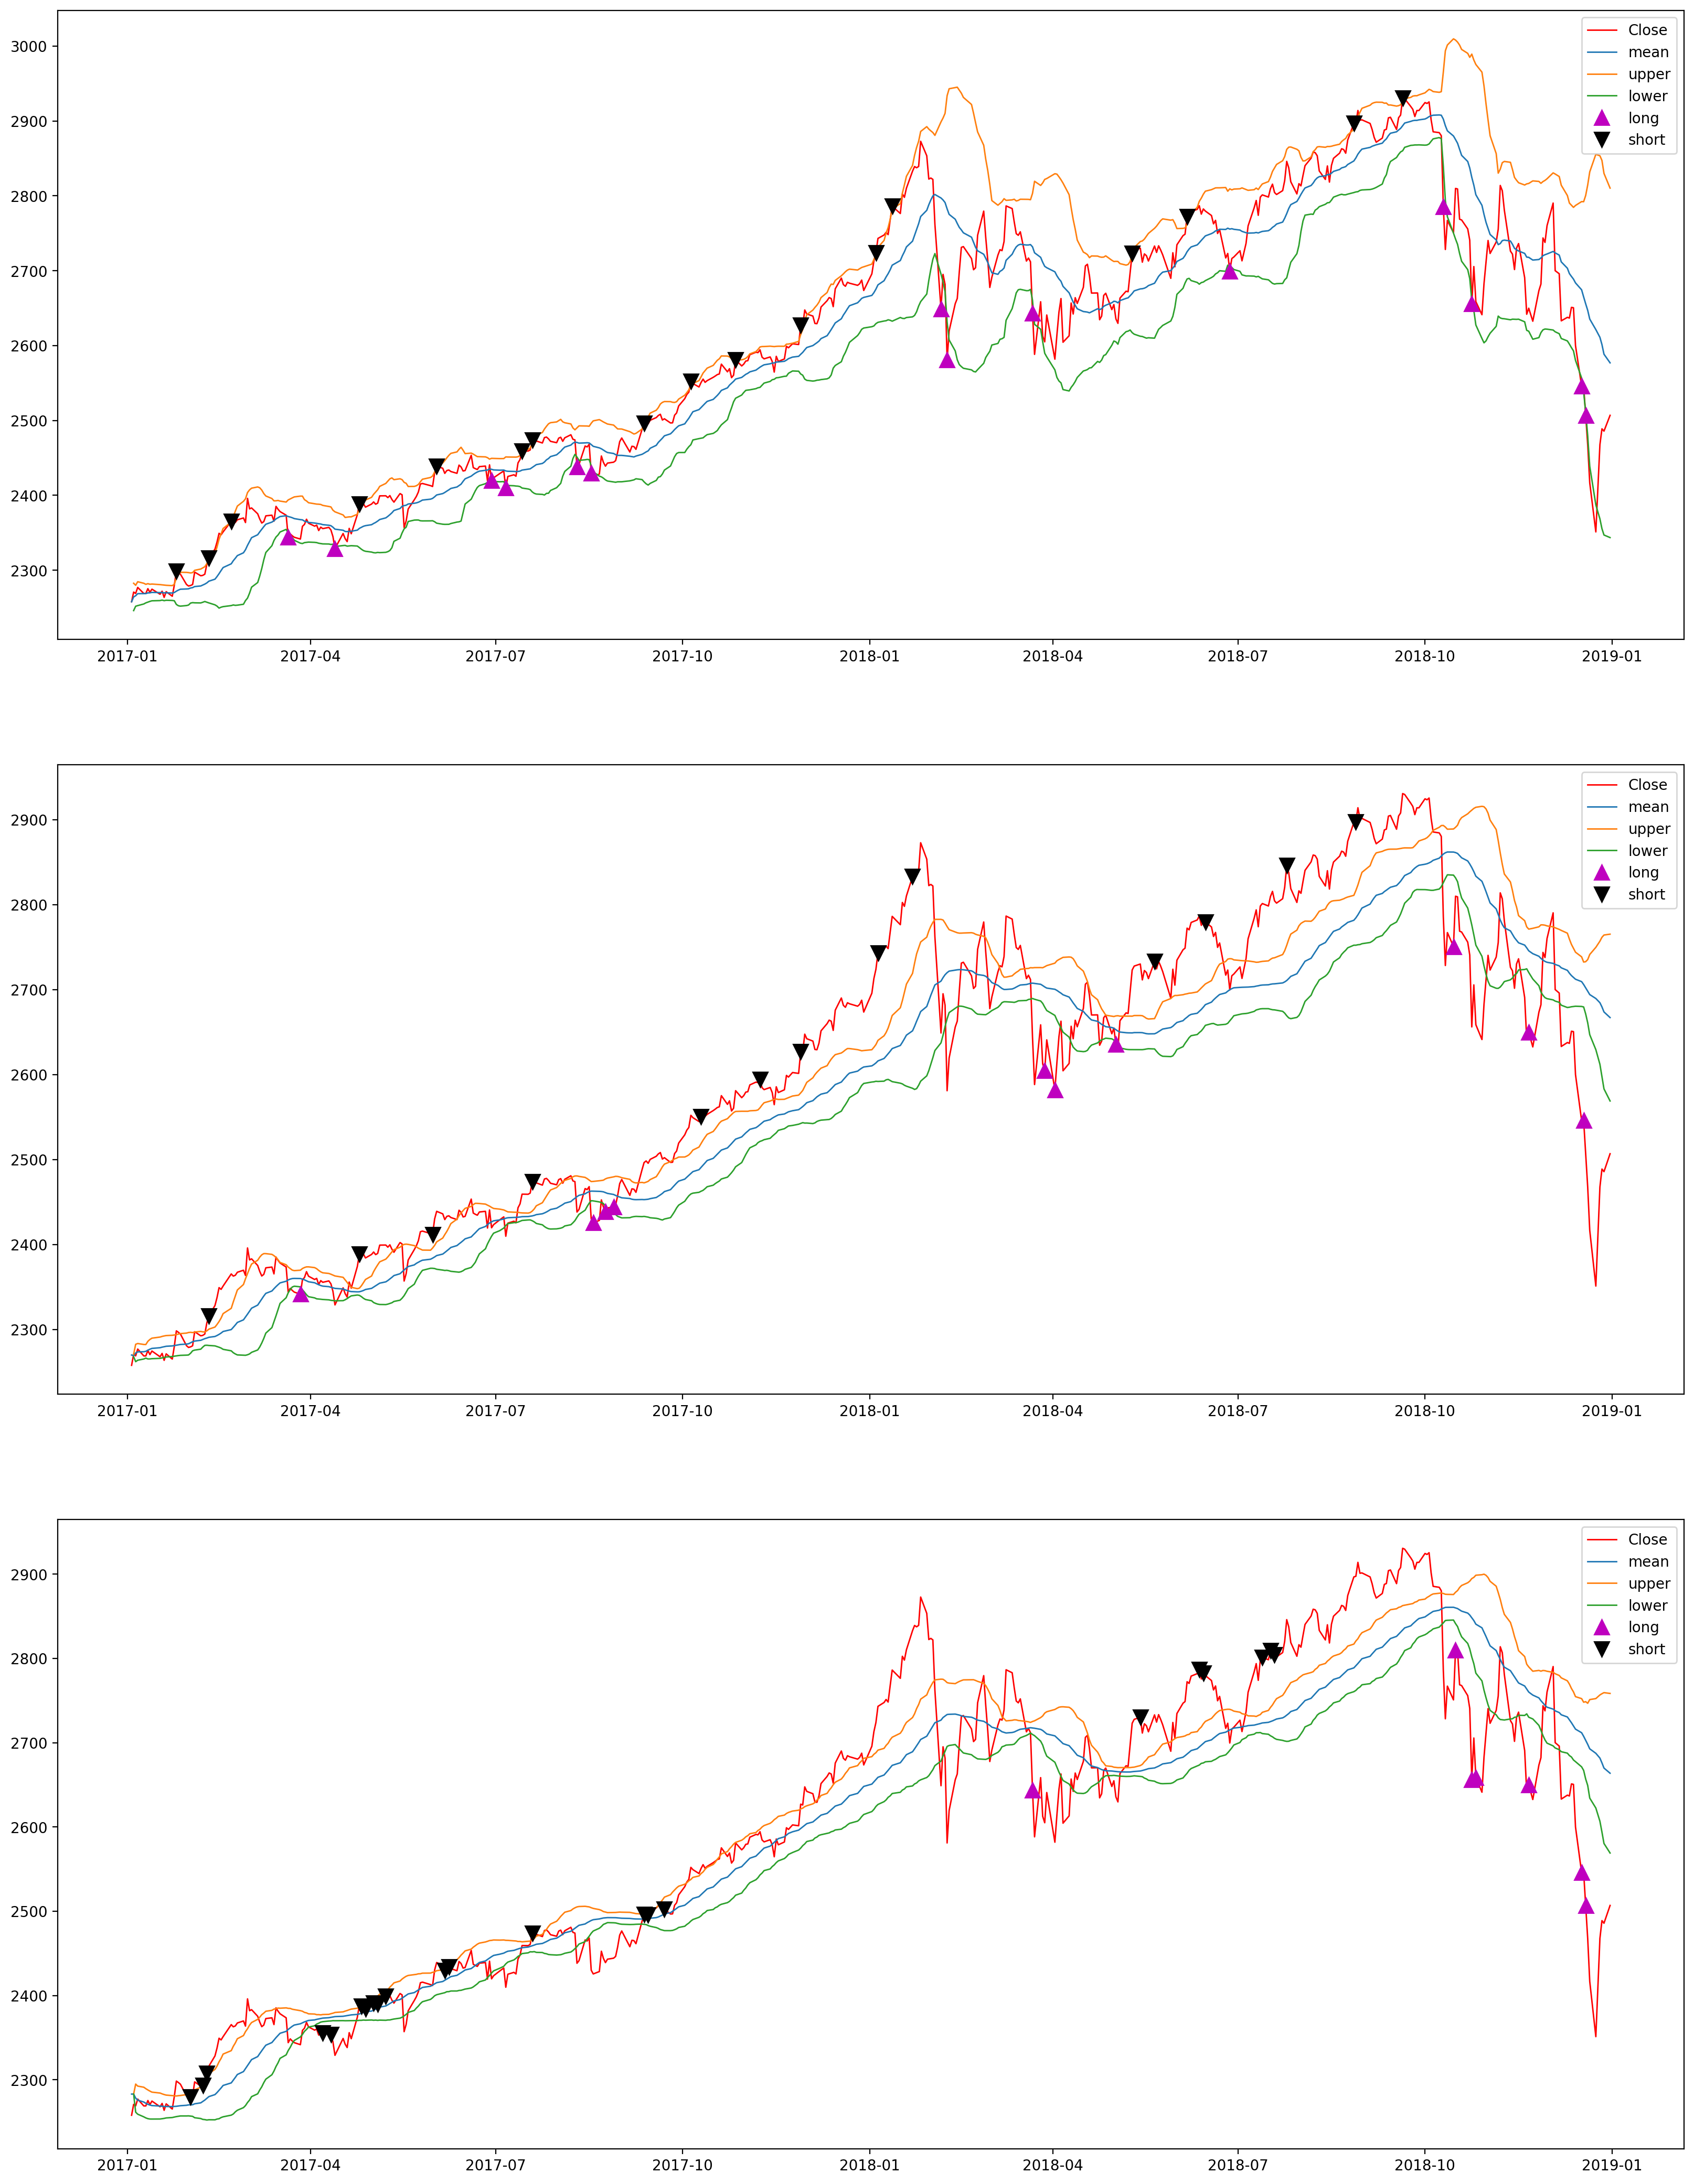

In [774]:
plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.plot(GSPC_test_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.plot(pure_mm_cnn_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.GSPC_test[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.GSPC_test[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()    

plt.subplot(3,1,3)
plt.plot(pure_mm_lstm_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == 1.0].index, 
         pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == -1.0].index, 
         pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

## MACD

In [62]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

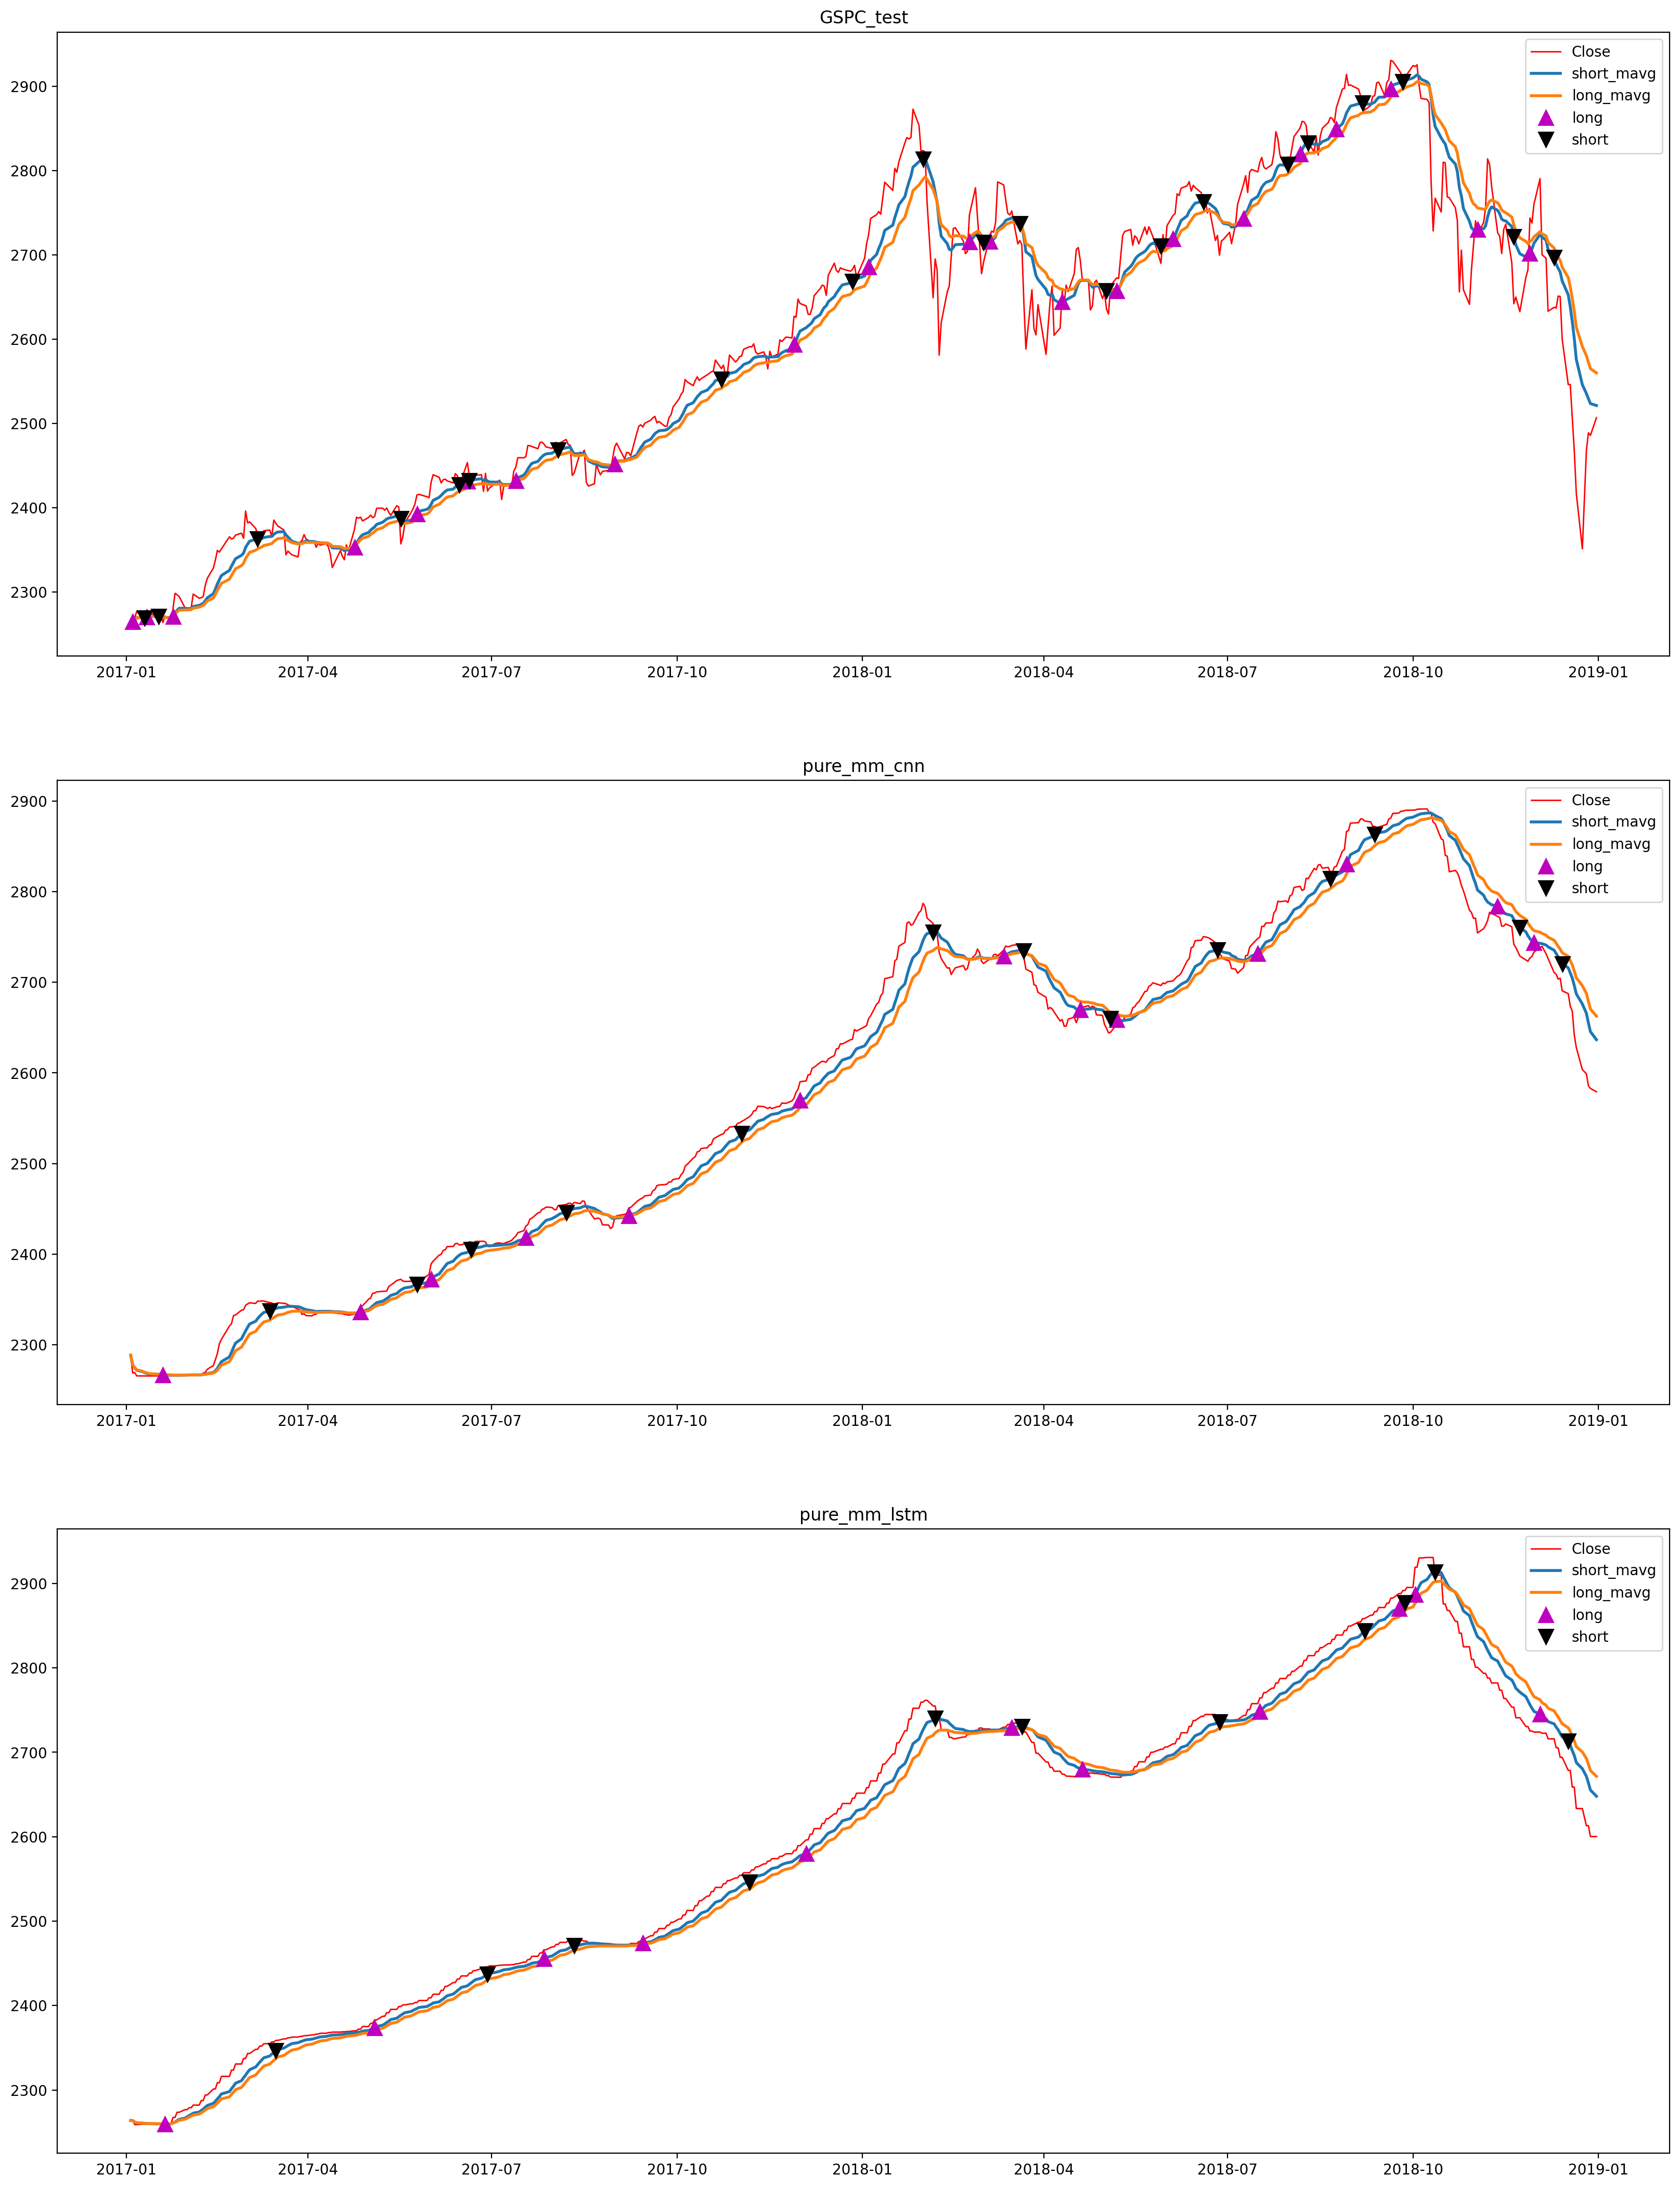

In [63]:
GSPC_test_macd=MACD(GSPC_test,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

plt.subplot(3,1,3)
plt.title('pure_mm_lstm')
plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == 1.0].index, 
         pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == -1.0].index, 
         pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

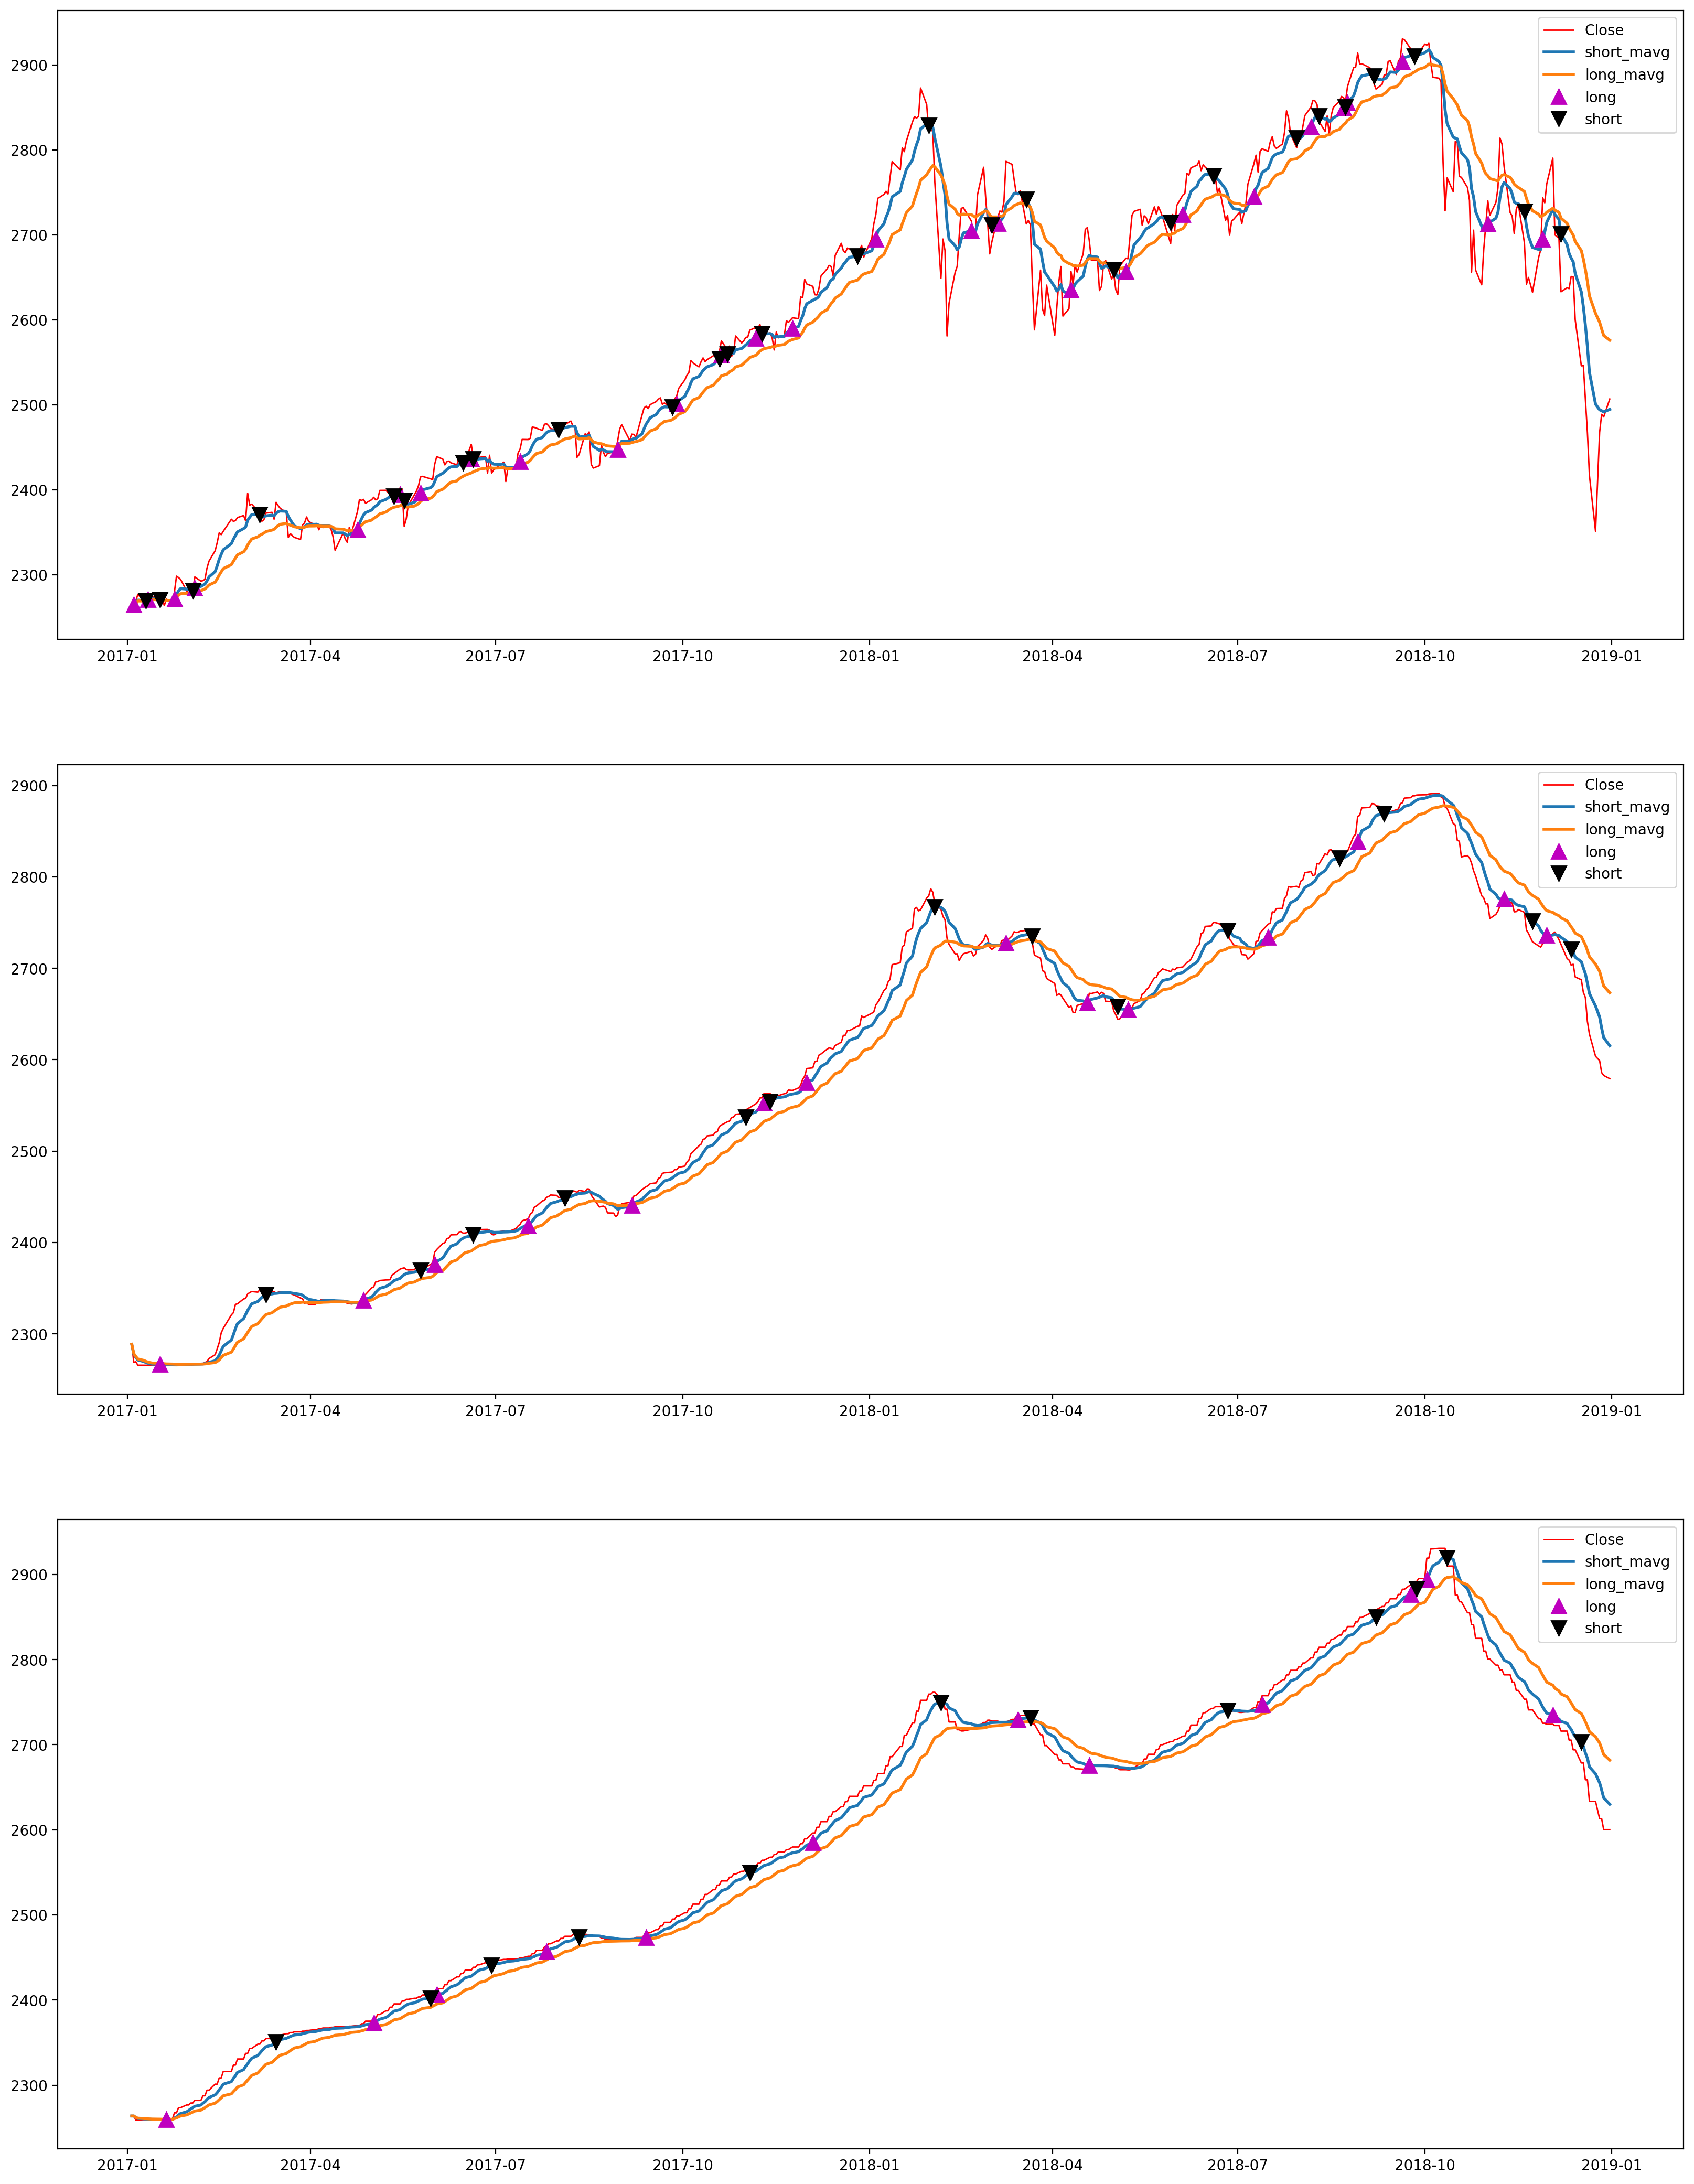

In [64]:
GSPC_test_macd9=MACD(GSPC_test,short_window = 9,long_window = 26)
pure_mm_cnn_macd9=MACD(pure_mm_cnn,short_window = 9,long_window = 26)
pure_mm_lstm_macd9=MACD(pure_mm_lstm,short_window = 9,long_window = 26)

plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd9.loc[GSPC_test_macd9.positions == 1.0].index, 
         GSPC_test_macd9.short_mavg[GSPC_test_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_macd9.loc[GSPC_test_macd9.positions == -1.0].index, 
         GSPC_test_macd9.short_mavg[GSPC_test_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.plot(pure_mm_cnn['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd9.loc[pure_mm_cnn_macd9.positions == 1.0].index, 
         pure_mm_cnn_macd9.short_mavg[pure_mm_cnn_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_macd9.loc[pure_mm_cnn_macd9.positions == -1.0].index, 
         pure_mm_cnn_macd9.short_mavg[pure_mm_cnn_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

plt.subplot(3,1,3)
plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_lstm_macd9.loc[pure_mm_lstm_macd9.positions == 1.0].index, 
         pure_mm_lstm_macd9.short_mavg[pure_mm_lstm_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_macd9.loc[pure_mm_lstm_macd9.positions == -1.0].index, 
         pure_mm_lstm_macd9.short_mavg[pure_mm_lstm_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

In [65]:
GSPC_test[GSPC_test_macd['positions']==1]

Close   log_ret
Date                             
2017-01-04  2270.750000  0.005706
2017-01-11  2275.320068  0.002826
2017-01-24  2280.070068  0.006543
2017-04-24  2374.149902  0.010782
2017-05-25  2415.070068  0.004432
2017-06-19  2453.459961  0.008313
2017-07-13  2447.830078  0.001873
2017-08-31  2471.649902  0.005705
2017-11-28  2627.040039  0.009800
2018-01-04  2723.989990  0.004021
2018-02-23  2747.300049  0.015901
2018-03-05  2720.939941  0.010972
2018-04-10  2656.870117  0.016589
2018-05-07  2672.629883  0.003452
2018-06-04  2746.870117  0.004470
2018-07-09  2784.169922  0.008784
2018-08-06  2850.399902  0.003532
2018-08-24  2874.689941  0.006180
2018-09-20  2930.750000  0.007810
2018-11-02  2723.060059 -0.006337
2018-11-28  2743.790039  0.022714

## MA

In [66]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

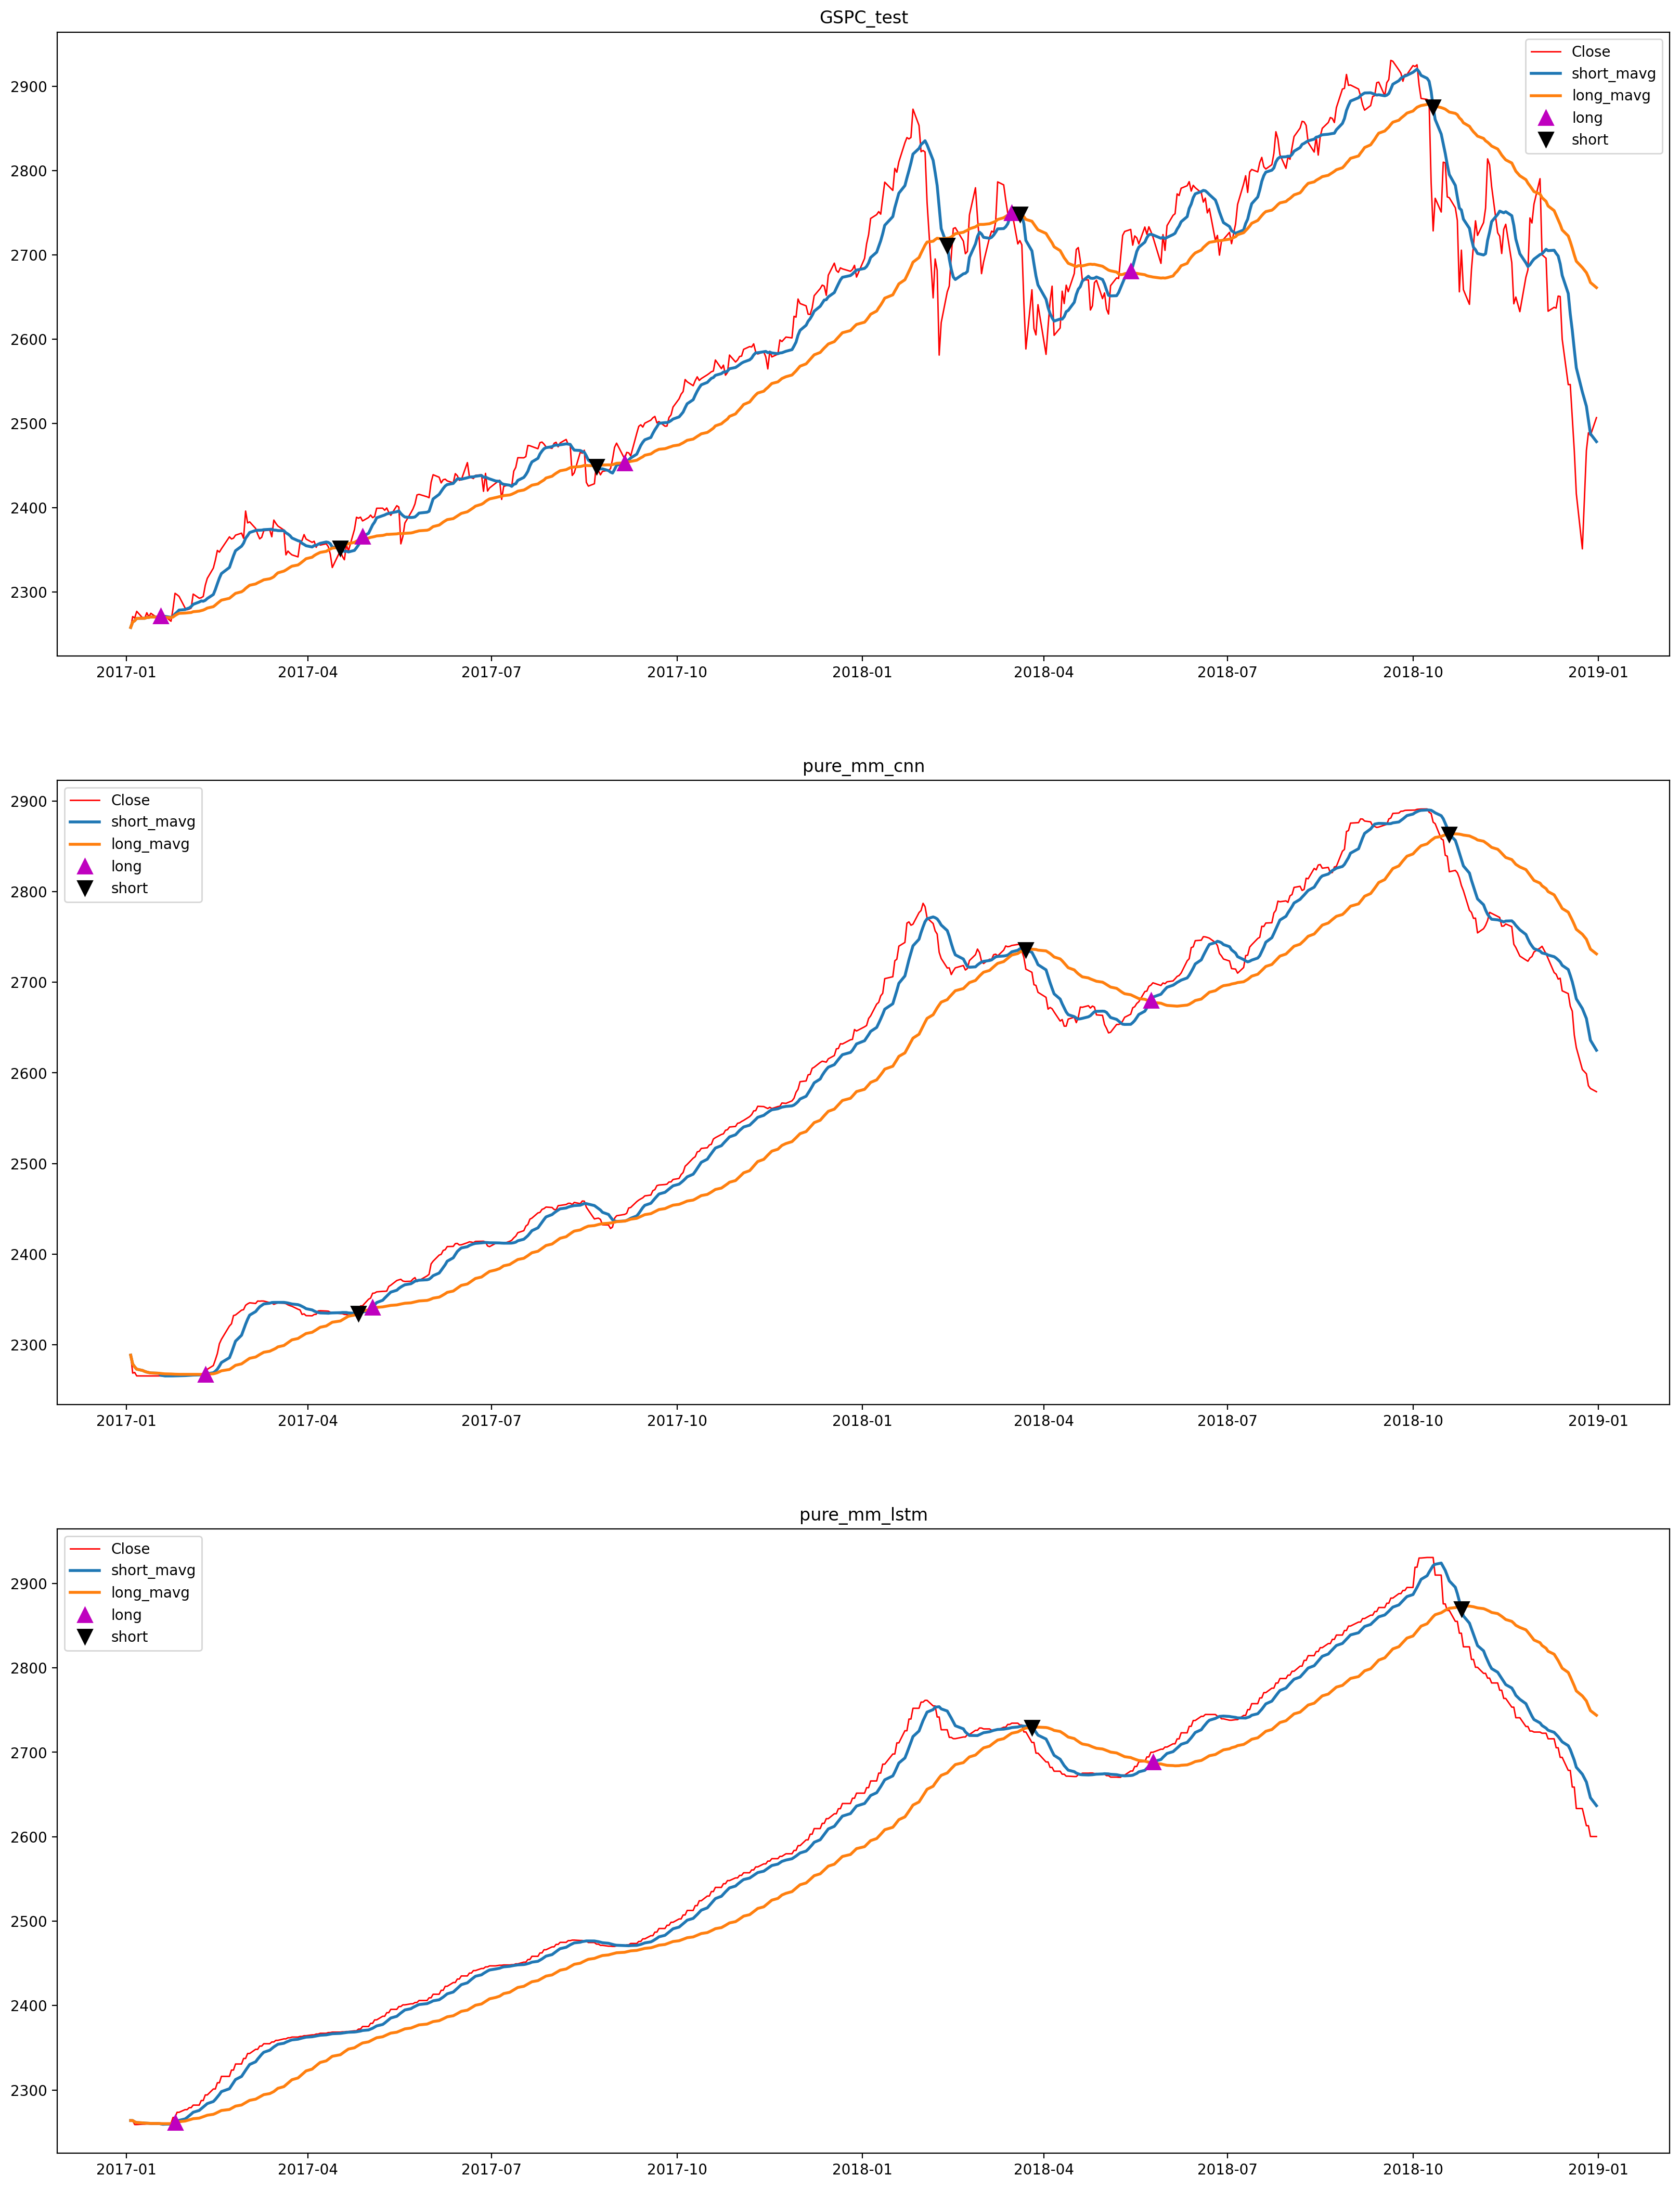

In [67]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

plt.subplot(3,1,3)
plt.title('pure_mm_lstm')
plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == 1.0].index, 
         pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_ma.loc[pure_mm_lstm_ma.positions == -1.0].index, 
         pure_mm_lstm_ma.short_mavg[pure_mm_lstm_ma.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

In [68]:
GSPC_test[GSPC_test_ma['positions']==1]

Close   log_ret
Date                             
2017-01-18  2271.889893  0.001762
2017-04-28  2384.199951 -0.001915
2017-09-05  2457.850098 -0.007579
2018-03-16  2752.010010  0.001702
2018-05-14  2730.129883  0.000883

In [125]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Close']=dataset['Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [128]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)
pure_mm_lstm_backtesting=combinesig(GSPC_test,pure_mm_lstm_ma,pure_mm_lstm_macd,pure_mm_lstm_signal)

In [129]:
pure_mm_cnn_backtesting

Close  masig  macdsig  bbsig
Date                                          
2017-01-03  2257.830078    NaN      NaN    NaN
2017-01-04  2270.750000    0.0      0.0    NaN
2017-01-05  2269.000000    0.0      0.0    NaN
2017-01-06  2276.979980    0.0      0.0    NaN
2017-01-09  2268.899902    0.0      0.0    NaN
...                 ...    ...      ...    ...
2018-12-24  2351.100098    0.0      0.0    NaN
2018-12-26  2467.699951    0.0      0.0    NaN
2018-12-27  2488.830078    0.0      0.0    NaN
2018-12-28  2485.739990    0.0      0.0    NaN
2018-12-31  2506.850098    0.0      0.0    NaN

[502 rows x 4 columns]

In [127]:
GSPC_backtesting.describe()

Close       masig     macdsig      bbsig
count   502.000000  501.000000  501.000000  31.000000
mean   2597.645281    0.000000    0.000000  -0.096774
std     181.994087    0.141421    0.289828   1.011759
min    2257.830078   -1.000000   -1.000000  -1.000000
25%    2434.777527    0.000000    0.000000  -1.000000
50%    2629.420044    0.000000    0.000000  -1.000000
75%    2742.534912    0.000000    0.000000   1.000000
max    2930.750000    1.000000    1.000000   1.000000

In [113]:
GSPC_backtesting['masig'][1]

0.0

In [138]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=cash//(100*dataset['Close'][i])*100
            cash=cash-share_number*dataset['Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [132]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)
print(mareturn_lstm)

0.13375734350585938
0.13756264111328126
0.14998026611328125


In [133]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
print(mareturn_lstm)

0.0422089462890625
-0.00744155419921875
-0.025333835693359376


In [139]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)
print(mareturn_lstm)

-0.9985525283203125
-0.9997696184082031
-0.9990997788085938
